In [1]:
import os
import math
import glob
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import torch
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from transformers import ViTModel, ViTConfig
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.optim import lr_scheduler
from tensorboard.backend.event_processing import event_accumulator

from src.datamodules.msg_af_dataloader import MSGAFDataModule
from src.transforms.msg_transforms import MSGTransform

/home/jupyter-nanastasiou/.conda/envs/seviri/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'transformers'

In [2]:
# Define paths
MSG_PATH = "/home/jupyter-kalexis/and_project_shared/data/originals/seviri/semanntic_segmentation_dev/pointcloud_5/images"
AF_PATH = "/home/jupyter-kalexis/and_project_shared/data/originals/seviri/semanntic_segmentation_dev/pointcloud_5/masks"
BAND_INFO_PATH = "/home/jupyter-kalexis/and_project_private/and_representation-learning-baselines/fire_fm/aux_data/msg/msg_band_info_250samples.json"

# Define transforms
transforms = {"msg": MSGTransform(band_info_path=BAND_INFO_PATH)}

splits_dict = {
    "train": {"years": [2020, 2021], "months": [5, 6, 7, 8, 9], "days": list(range(1, 32))},
    "val": {"years": [2022], "months": [5, 6, 7, 8, 9], "days": list(range(1, 32))},
    "test": {"years": [2023, 2024], "months": [5, 6, 7, 8, 9], "days": list(range(1, 32))},
}

In [3]:
# Initialize datamodule
msg_af_datamodule = MSGAFDataModule(
    af_dir=AF_PATH,
    msg_dir=MSG_PATH,
    splits_dict=splits_dict,
    transforms=transforms,
    ext="tif",
    batch_size=64,
    num_workers=8,
    pin_memory=True,
    prefetch_factor=4,
    daytime_only=False,  # restricts msg-cloudsat files to daytime
    load_time=False,
    num_timesteps=1,
    load_center_coords=False,
    task_seg=True,  # for segmentation tasks, used to transform nans to -1's after expansion to cube
)

# Dataset lengths
print(
    "train:", len(msg_af_datamodule.train_dataset),
    "val:", len(msg_af_datamodule.val_dataset),
    "test:", len(msg_af_datamodule.test_dataset),
)

train: 2140 val: 1099 test: 2873


Index 1: Image torch.Size([11, 32, 32]), min/max: -0.6179989576339722/5.764803886413574, Mask torch.Size([1, 32, 32]), min/max: 0.0/1.0


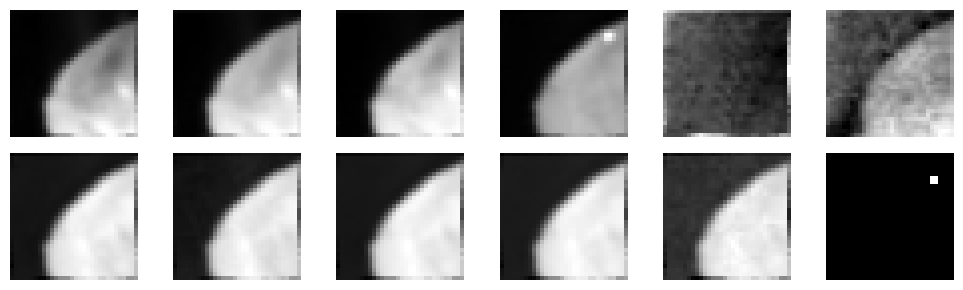

Index 10: Image torch.Size([11, 32, 32]), min/max: -2.766901969909668/6.494414329528809, Mask torch.Size([1, 32, 32]), min/max: 0.0/1.0


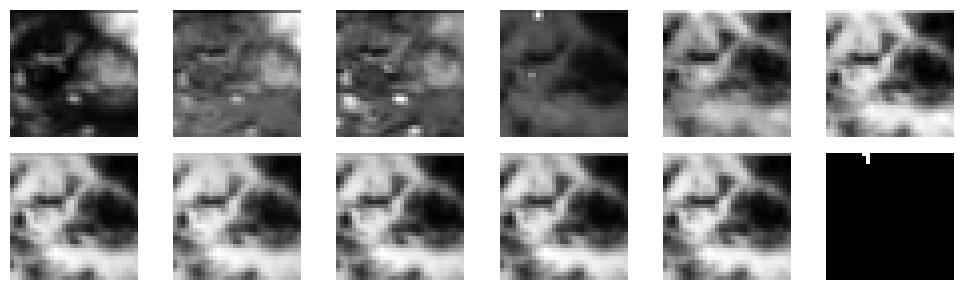

Index 100: Image torch.Size([11, 32, 32]), min/max: -0.7570641040802002/3.897721767425537, Mask torch.Size([1, 32, 32]), min/max: 0.0/1.0


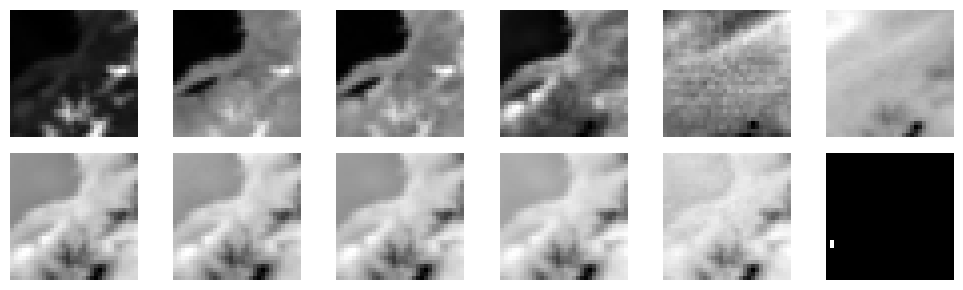

In [4]:
def plot_images_and_masks(ds, indexes):
    for idx in indexes:
        img, mask = ds[idx]
        print(f"Index {idx}: Image {img.shape}, min/max: {img.min()}/{img.max()}, Mask {mask.shape}, min/max: {mask.min()}/{mask.max()}")

        fig, axes = plt.subplots(2, 6, figsize=(10, 3))
        axes = axes.flatten()
        for i in range(img.shape[0]):
            axes[i].imshow(img[i], cmap="gray"); axes[i].axis("off")
        axes[11].imshow(mask.squeeze(), cmap="gray"); axes[11].axis("off")

        plt.tight_layout(); plt.show()


plot_images_and_masks(
    msg_af_datamodule.train_dataset, [1, 10, 100]
)  # Pass the dataset and a list of indices you want to plot

Index 0: Image torch.Size([11, 32, 32]), min/max: -0.630163848400116/4.531527042388916, Mask torch.Size([1, 32, 32]), min/max: 0.0/0.0


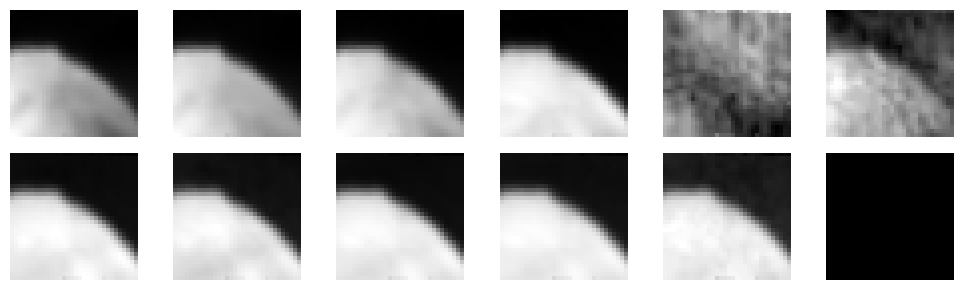

Index 0: Image torch.Size([11, 32, 32]), min/max: -0.7020357847213745/5.447569847106934, Mask torch.Size([1, 32, 32]), min/max: 0.0/1.0


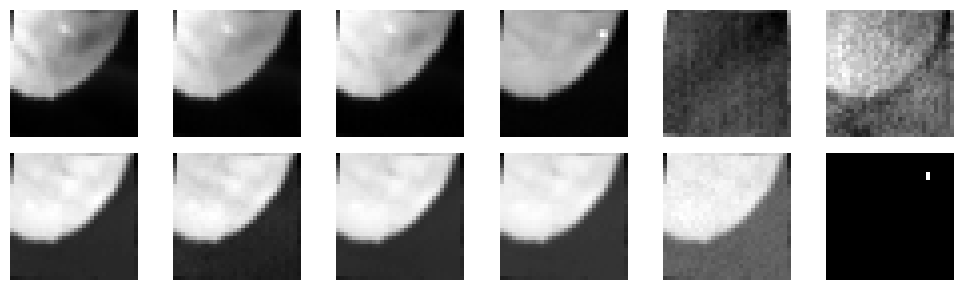

Index 0: Image torch.Size([11, 32, 32]), min/max: -0.7042146921157837/5.581021308898926, Mask torch.Size([1, 32, 32]), min/max: 0.0/1.0


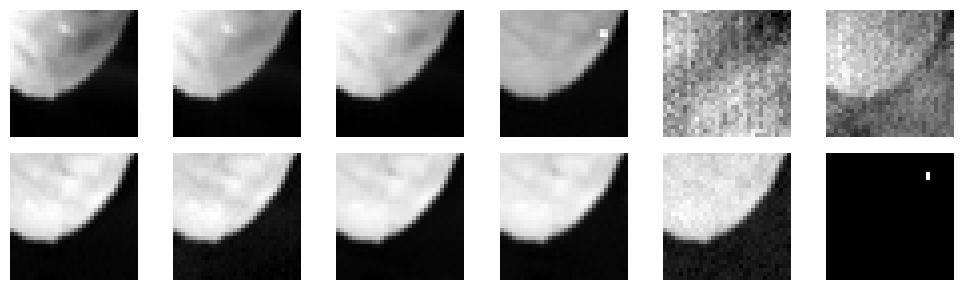

Index 0: Image torch.Size([11, 32, 32]), min/max: -0.6998568773269653/5.499395370483398, Mask torch.Size([1, 32, 32]), min/max: 0.0/1.0


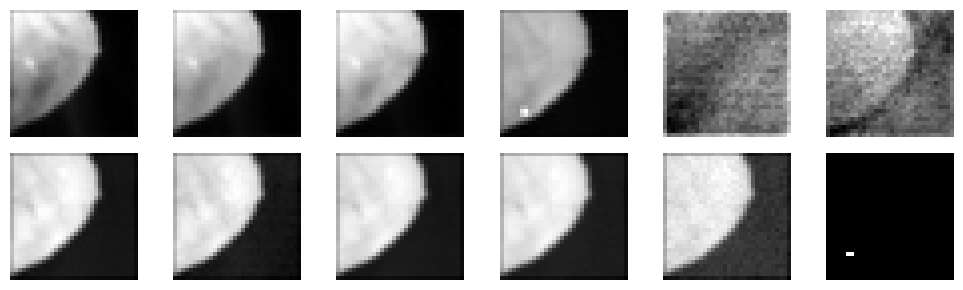

Index 0: Image torch.Size([11, 32, 32]), min/max: -0.7042146921157837/5.581021308898926, Mask torch.Size([1, 32, 32]), min/max: 0.0/1.0


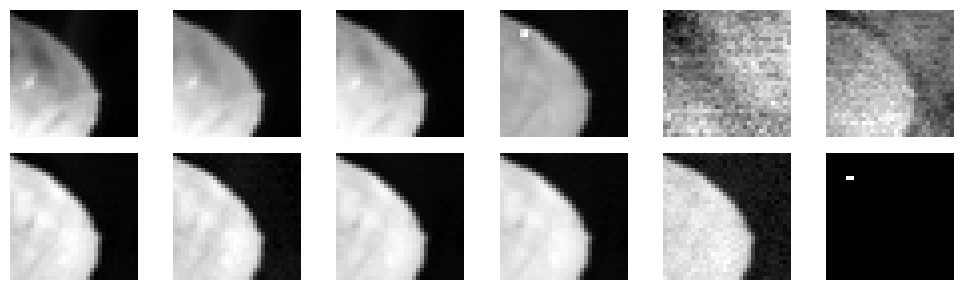

Index 0: Image torch.Size([11, 32, 32]), min/max: -0.7042146921157837/5.581021308898926, Mask torch.Size([1, 32, 32]), min/max: 0.0/1.0


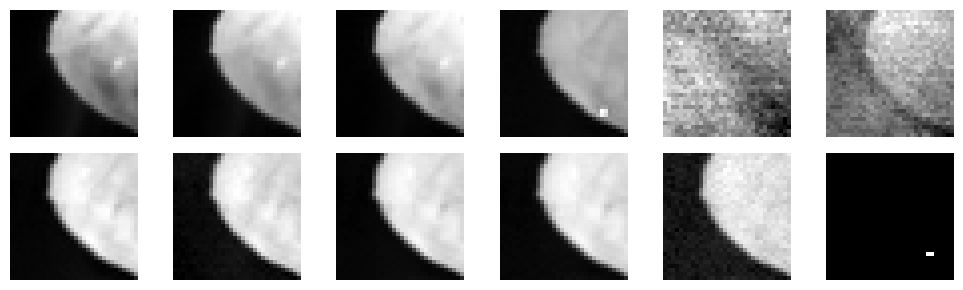

Index 0: Image torch.Size([11, 32, 32]), min/max: -0.6988354921340942/5.507229804992676, Mask torch.Size([1, 32, 32]), min/max: 0.0/1.0


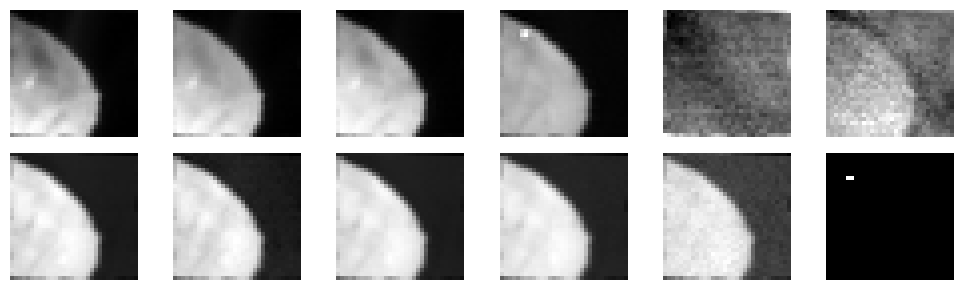

Index 0: Image torch.Size([11, 32, 32]), min/max: -0.6835415959358215/5.34767484664917, Mask torch.Size([1, 32, 32]), min/max: 0.0/1.0


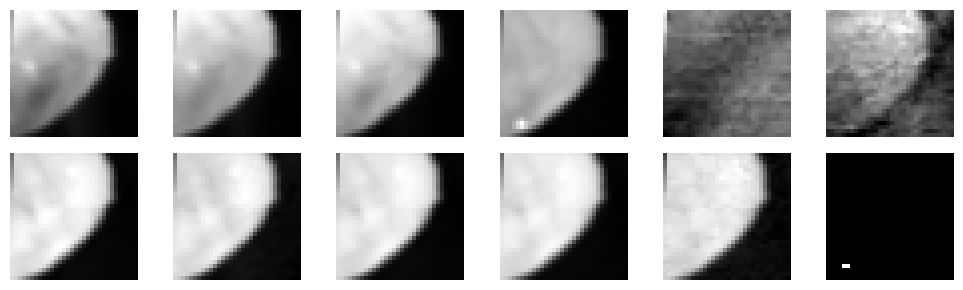

Index 0: Image torch.Size([11, 32, 32]), min/max: -0.6879014372825623/5.18855619430542, Mask torch.Size([1, 32, 32]), min/max: 0.0/1.0


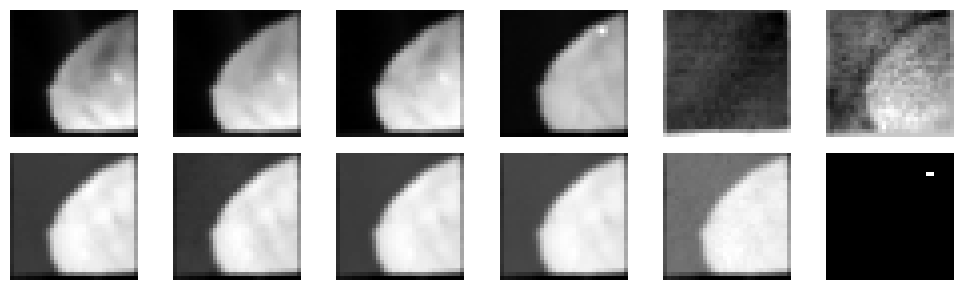

Index 0: Image torch.Size([11, 32, 32]), min/max: -0.6988780498504639/5.378167152404785, Mask torch.Size([1, 32, 32]), min/max: 0.0/1.0


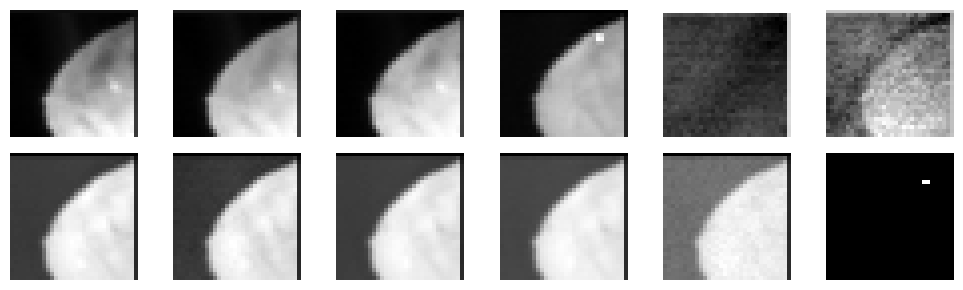

In [5]:
plot_images_and_masks(
    msg_af_datamodule.train_dataset, [0] * 10
)  # Plot the same image several times to showcase data augmentation

In [6]:
# Some training hyperparameters
EPOCHS = 75
T_MAX = EPOCHS * len(msg_af_datamodule.train_dataloader())
OUT_CLASSES = 2
# CLASS_WEIGHTS = [1.0, 500.0]

In [7]:
class ResidualConv(torch.nn.Module):
    def __init__(self, input_dim, output_dim, stride, padding):
        super().__init__()

        self.conv_block = torch.nn.Sequential(
            torch.nn.BatchNorm2d(input_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(
                input_dim, output_dim, kernel_size=3, stride=stride, padding=padding
            ),
            torch.nn.BatchNorm2d(output_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1),
        )
        self.conv_skip = torch.nn.Sequential(
            torch.nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1),
            torch.nn.BatchNorm2d(output_dim),
        )

    def forward(self, x):
        x1 = self.conv_block(x)
        x2 = self.conv_skip(x)
        return x1 + x2


class Upsample(torch.nn.Module):
    def __init__(self, input_dim, output_dim, kernel, stride):
        super().__init__()

        self.upsample = torch.nn.ConvTranspose2d(
            input_dim, output_dim, kernel_size=kernel, stride=stride
        )

    def forward(self, x):
        return self.upsample(x)

In [8]:
class Permute(torch.nn.Module):
    def __init__(self, *dims):
        super().__init__()
        self.dims = dims

    def forward(self, x):
        return x.permute(*self.dims)


class RemoveClassToken(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x[:, 1:, :]


class ReshapeToken(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        bs, hd, ps2 = x.shape
        ps = int(math.sqrt(ps2))
        x = x.reshape(bs, hd, ps, ps)
        return x


class UpBlock(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.up = Upsample(input_dim, output_dim, kernel=2, stride=2)
        self.resconv = ResidualConv(output_dim, output_dim, 1, 1)

    def forward(self, x):
        x = self.up(x)
        return self.resconv(x)
    
class Classify(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.num_classes = num_classes
        self.perm1 = Permute(0, 2, 3, 1)
        self.perm2 = Permute(0, 4, 3, 1, 2)

    def forward(self, x):
        print("classify", x.shape)
        x = self.perm1(x)
        print("classify", x.shape)
        bs, ps, ps, nf = x.shape
        nf = nf // (self.num_classes)
        x = x.reshape(bs, ps, ps, nf, self.num_classes)
        print("classify", x.shape)
        x = self.perm2(x)
        print("classify", x.shape)

        return x

In [9]:
# Define model
class MSGAFModel(pl.LightningModule):
    def __init__(self, in_channels, out_classes):
        super().__init__()

        config = ViTConfig.from_pretrained('project-ieroklis/pre-trained_models/Prithvi_EO_V1_100M.pt')
        config.num_channels = 11
        config.image_size = 32
        config.patch_size = 4

        self.encoder = ViTModel(config)

        # Conv -> syncbn -> relu -> interpolate x2 until input resolution
        num_patches_dim = config.image_size // config.patch_size #8
        if config.image_size / num_patches_dim <= 2:
            raise ValueError("Patches are too small to construct deconv decoder")
        # in size (b, num_patches, num_patches, h)
        # out size (b, self.output_size, self.output_size,)

        layers = []

        layers.extend(
            [
                torch.nn.Conv2d(768, 256, kernel_size=3, stride=1, padding=1),
                torch.nn.SyncBatchNorm(256),
                torch.nn.ReLU(inplace=True),
                torch.nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False),
            ]
        )

        current_size = num_patches_dim * 2

        while current_size * 2 < config.image_size:  # While we can still scale *2
            layers.extend(
                [
                    torch.nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                    torch.nn.SyncBatchNorm(256),
                    torch.nn.ReLU(inplace=True),
                    torch.nn.Upsample(
                        scale_factor=2, mode="bilinear", align_corners=False
                    ),
                ]
            )

            current_size = current_size * 2

        # Final layer
        layers.extend(
            [
                torch.nn.Conv2d(
                    256, out_classes, kernel_size=3, stride=1, padding=1
                ),
                #nn.SyncBatchNorm(self.num_classes),
                #nn.ReLU(),
                torch.nn.Upsample(
                    size=(config.image_size, config.image_size),
                    mode="bilinear",
                    align_corners=False,
                ),
            ]
        )

        self.decoder = torch.nn.Sequential(*layers)

        # class_weights = torch.tensor(CLASS_WEIGHTS, dtype=torch.float32)
        # self.loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
        self.loss_fn = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE)

        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        patch_embeddings = self.encoder(image).last_hidden_state[:, 1:]
        patch_embeddings_reshaped = patch_embeddings.permute(0, 2, 1).reshape(patch_embeddings.shape[0], 768, 32//4, 32//4)
        mask = self.decoder(patch_embeddings_reshaped)
        return mask

    def shared_step(self, batch, stage):
        image, mask = batch

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        mask = mask.squeeze(1).long()

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Get the predicted class for each pixel (the class with the highest logit)
        _, pred_mask = torch.max(logits_mask, dim=1)

        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="multiclass", num_classes=OUT_CLASSES
        )
        return {"loss": loss, "tp": tp, "fp": fp, "fn": fn, "tn": tn}

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        iou_micro = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        iou0 = (
            torch.sum(tp[:, 0])
            / (torch.sum(tp[:, 0]) + torch.sum(fp[:, 0]) + torch.sum(fn[:, 0]))
            if (torch.sum(tp[:, 0]) + torch.sum(fp[:, 0]) + torch.sum(fn[:, 0])) > 0
            else 0.0
        )
        iou1 = (
            torch.sum(tp[:, 1])
            / (torch.sum(tp[:, 1]) + torch.sum(fp[:, 1]) + torch.sum(fn[:, 1]))
            if (torch.sum(tp[:, 1]) + torch.sum(fp[:, 1]) + torch.sum(fn[:, 1])) > 0
            else 0.0
        )

        acc_micro = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro")

        precision0 = (
            torch.sum(tp[:, 0]) / (torch.sum(tp[:, 0]) + torch.sum(fp[:, 0]))
            if (torch.sum(tp[:, 0]) + torch.sum(fp[:, 0])) > 0
            else 0.0
        )
        precision1 = (
            torch.sum(tp[:, 1]) / (torch.sum(tp[:, 1]) + torch.sum(fp[:, 1]))
            if (torch.sum(tp[:, 1]) + torch.sum(fp[:, 1])) > 0
            else 0.0
        )

        recall0 = (
            torch.sum(tp[:, 0]) / (torch.sum(tp[:, 0]) + torch.sum(fn[:, 0]))
            if (torch.sum(tp[:, 0]) + torch.sum(fn[:, 0])) > 0
            else 0.0
        )
        recall1 = (
            torch.sum(tp[:, 1]) / (torch.sum(tp[:, 1]) + torch.sum(fn[:, 1]))
            if (torch.sum(tp[:, 1]) + torch.sum(fn[:, 1])) > 0
            else 0.0
        )

        balanced_acc = (recall0 + recall1) / 2

        metrics = {
            f"{stage}_loss": torch.stack([x["loss"] for x in outputs]).mean(dim=0),
            f"{stage}_acc_micro": acc_micro,
            f"{stage}_balanced_acc": balanced_acc,
            f"{stage}_iou_micro": iou_micro,
            f"{stage}_iou0": iou0,
            f"{stage}_iou1": iou1,
            f"{stage}_precision0": precision0,
            f"{stage}_precision1": precision1,
            f"{stage}_recall0": recall0,
            f"{stage}_recall1": recall1,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "interval": "step", "frequency": 1, },
        }

In [10]:
# Model initialization
model = MSGAFModel(in_channels=11, out_classes=OUT_CLASSES)

loss_checkpoint = ModelCheckpoint(
    save_weights_only=True, mode="min", monitor="valid_loss", filename="{valid_loss:.3f}-{epoch}-{step}"
)
balanced_acc_checkpoint = ModelCheckpoint(
    save_weights_only=True, mode="max", monitor="valid_balanced_acc", filename="{valid_balanced_acc:.3f}-{epoch}-{step}"
)
iou1_checkpoint = ModelCheckpoint(
    save_weights_only=True, mode="max", monitor="valid_iou1", filename="{valid_iou1:.3f}-{epoch}-{step}"
)

# Trainer setup
trainer = pl.Trainer(
    max_epochs=EPOCHS, log_every_n_steps=1, callbacks=[loss_checkpoint, balanced_acc_checkpoint, iou1_checkpoint],
)

# Train the model
trainer.fit(
    model,
    train_dataloaders=msg_af_datamodule.train_dataloader(),
    val_dataloaders=msg_af_datamodule.val_dataloader(),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | ViTModel   | 85.8 M | train
1 | decoder | Sequential | 1.8 M  | train
2 | loss_fn | DiceLoss   | 0      | train
-----------------------------------------------
87.6 M    Trainable params
0         Non-trainable params
87.6 M    Total params
350.432   Total estimated model params size (MB)
223       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=75` reached.


Loading from event file: /home/jupyter-kalexis/and_project_private/and_representation-learning-baselines/fire_fm/lightning_logs/version_0/events.out.tfevents.1747391476.ieroklis.812922.0


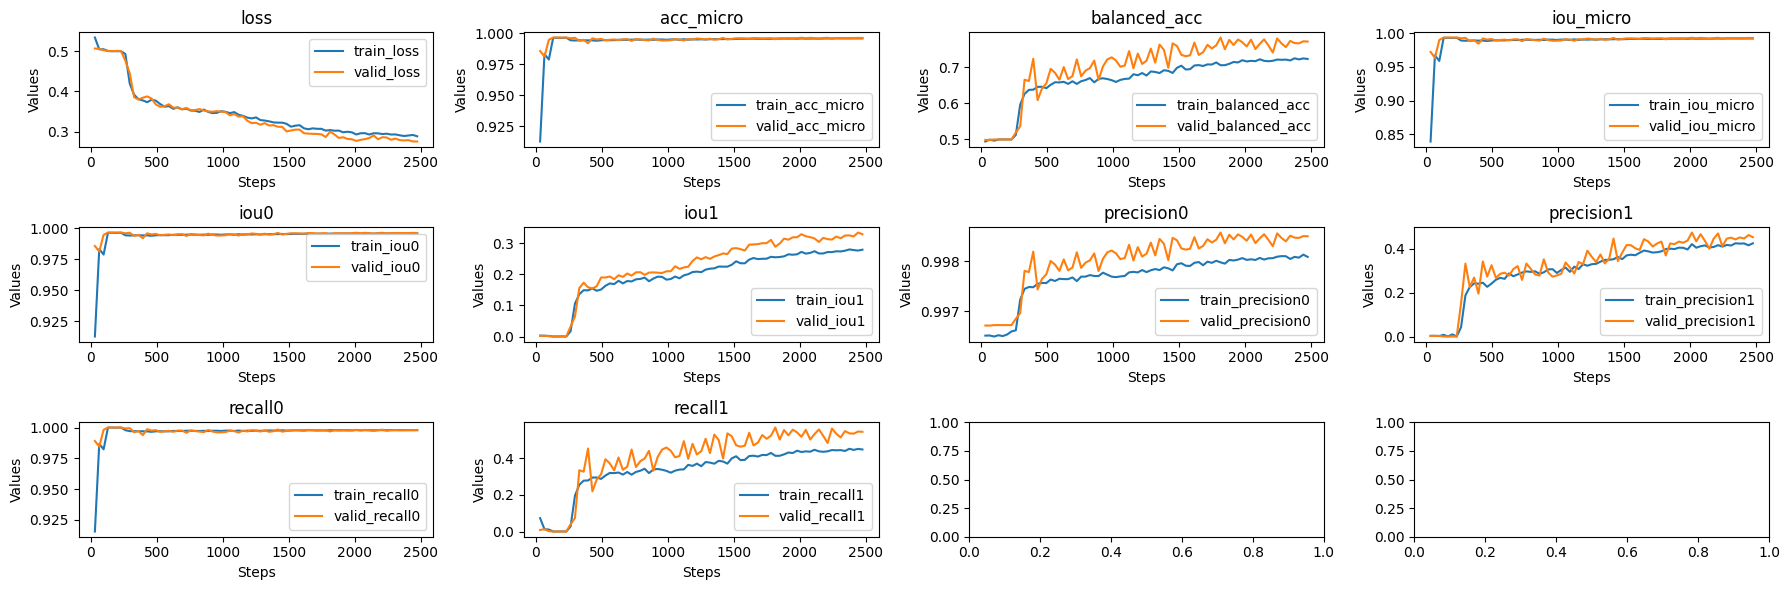

In [11]:
def plot_tensorboard_scalars(event_file):
    # Initialize event accumulator and load data
    event_acc = event_accumulator.EventAccumulator(event_file)
    event_acc.Reload()

    # Create subplots
    fig, axs = plt.subplots(3, 4, figsize=(18, 6))
    axs = axs.flatten()

    # Function to plot scalars based on prefix
    for idx, prefix in enumerate(['train', 'valid']):
        for i, tag in enumerate([t for t in event_acc.Tags()['scalars'] if t.startswith(prefix)]):
            steps, values = zip(*[(e.step, e.value) for e in event_acc.Scalars(tag)])
            axs[i].plot(steps, values, label=tag)
            axs[i].set(title='_'.join(tag.split('_')[1:]), xlabel='Steps', ylabel='Values')
            axs[i].legend()

    plt.tight_layout()
    plt.show()


latest_event_file = glob.glob(os.path.join(trainer.logger.log_dir, 'events.out.tfevents*'))[0]
print("Loading from event file:", latest_event_file)

plot_tensorboard_scalars(latest_event_file)

In [12]:
def visualize_predictions(ds, indexes, model):
    model.eval()
    for idx in indexes:
        img, mask = ds[idx]
        print(f"Index {idx}: Image {img.shape}, min/max: {img.min()}/{img.max()}, Mask {mask.shape}, min/max: {mask.min()}/{mask.max()}")

        with torch.no_grad():
            _, pred_mask = torch.max(model(img.unsqueeze(0)), dim=1)

        fig, axes = plt.subplots(2, 7, figsize=(10, 3))
        axes = axes.flatten()
        for i in range(img.shape[0]):
            axes[i].imshow(img[i], cmap="gray") if i < 6 else axes[i + 1].imshow(img[i], cmap="gray"); axes[i + 1].axis("off")
            axes[i].axis("off")
        axes[12].imshow(mask.squeeze(), cmap="gray"); axes[12].axis("off")
        axes[13].imshow(pred_mask.squeeze(), cmap="gray"); axes[13].axis("off")

        plt.tight_layout(); plt.show()

In [13]:
all_valid_metrics, all_test_metrics = [], []

Loading checkpoint from: /home/jupyter-kalexis/and_project_private/and_representation-learning-baselines/fire_fm/lightning_logs/version_0/checkpoints/valid_loss=0.276-epoch=74-step=2475.ckpt...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation results: {'valid_loss': 0.276, 'valid_acc_micro': 0.9964, 'valid_balanced_acc': 0.7714, 'valid_iou_micro': 0.9927, 'valid_iou0': 0.9964, 'valid_iou1': 0.3289, 'valid_precision0': 0.9985, 'valid_precision1': 0.4534, 'valid_recall0': 0.9978, 'valid_recall1': 0.5449}


Testing: |          | 0/? [00:00<?, ?it/s]

Test results: {'test_loss': 0.3326, 'test_acc_micro': 0.996, 'test_balanced_acc': 0.6773, 'test_iou_micro': 0.9921, 'test_iou0': 0.996, 'test_iou1': 0.2537, 'test_precision0': 0.9976, 'test_precision1': 0.4687, 'test_recall0': 0.9985, 'test_recall1': 0.3562}
Visualize predictions:
Index 0: Image torch.Size([11, 32, 32]), min/max: -2.5787763595581055/4.531582355499268, Mask (1, 32, 32), min/max: 0.0/1.0


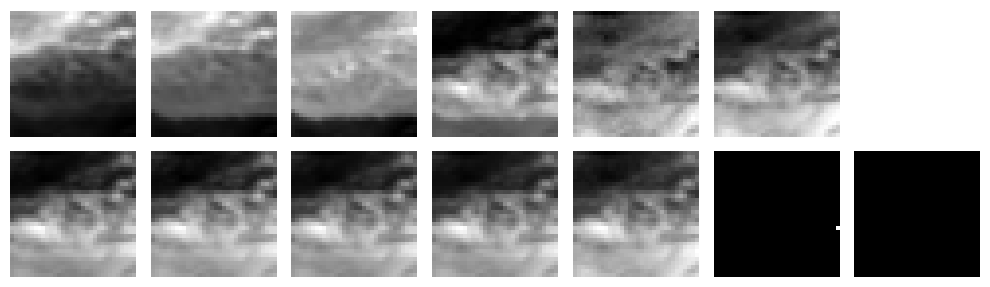

Index 1: Image torch.Size([11, 32, 32]), min/max: -0.9743996262550354/7.237942218780518, Mask (1, 32, 32), min/max: 0.0/1.0


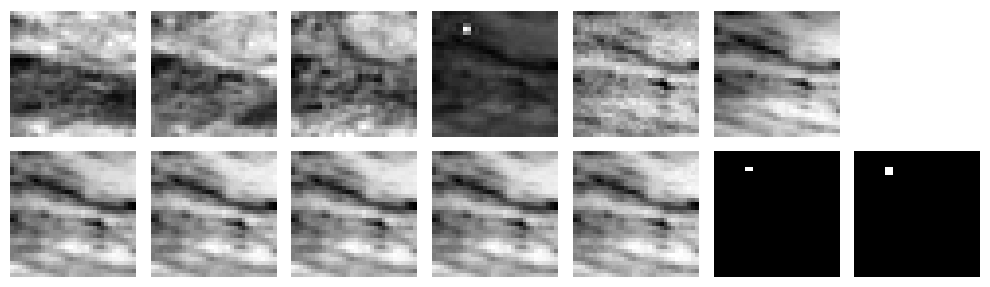

Index 2: Image torch.Size([11, 32, 32]), min/max: -1.0789875984191895/5.116130828857422, Mask (1, 32, 32), min/max: 0.0/1.0


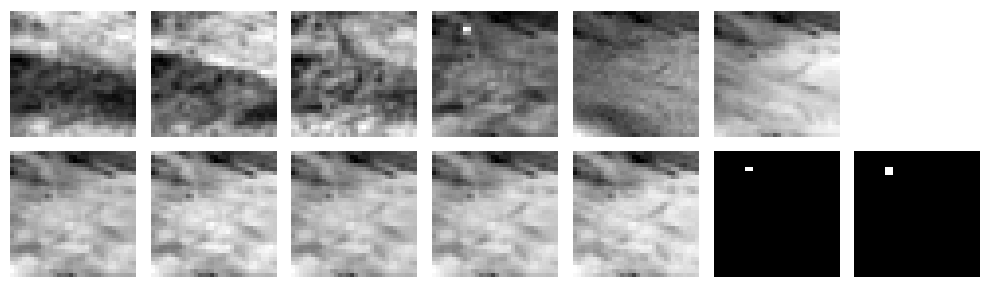

Index 3: Image torch.Size([11, 32, 32]), min/max: -1.7427973747253418/3.6618547439575195, Mask (1, 32, 32), min/max: 0.0/1.0


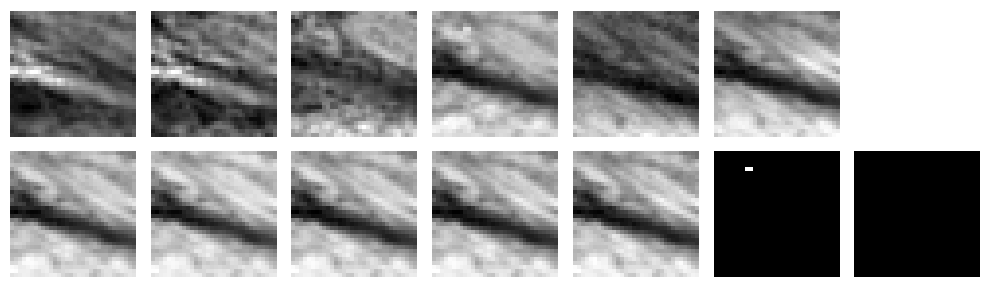

Index 4: Image torch.Size([11, 32, 32]), min/max: -1.4161896705627441/6.558485507965088, Mask (1, 32, 32), min/max: 0.0/1.0


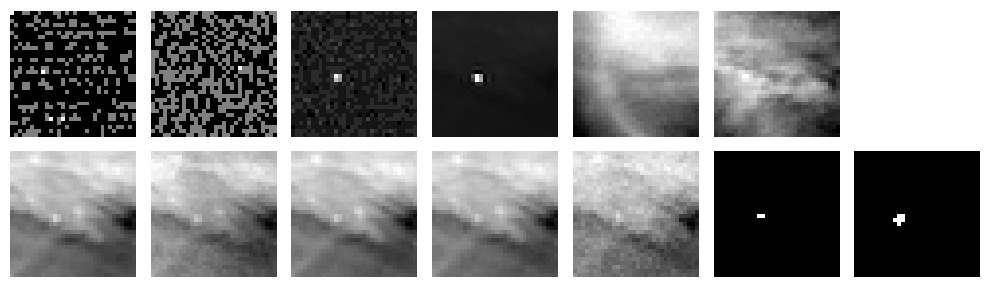

Index 5: Image torch.Size([11, 32, 32]), min/max: -1.0585808753967285/3.947941780090332, Mask (1, 32, 32), min/max: 0.0/1.0


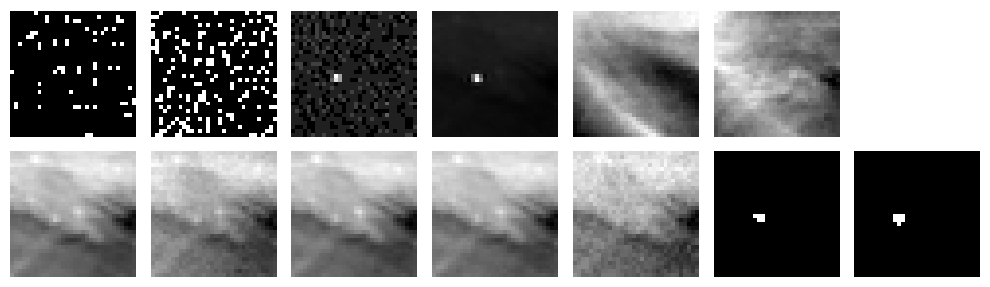

Index 6: Image torch.Size([11, 32, 32]), min/max: -1.0705012083053589/2.386383533477783, Mask (1, 32, 32), min/max: 0.0/1.0


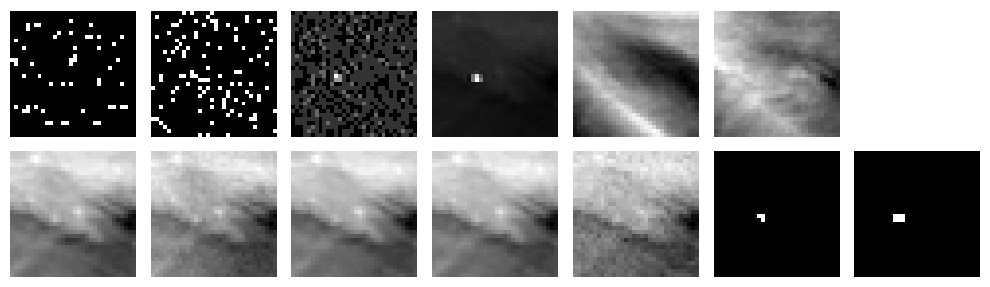

Index 7: Image torch.Size([11, 32, 32]), min/max: -1.0824214220046997/1.2393742799758911, Mask (1, 32, 32), min/max: 0.0/1.0


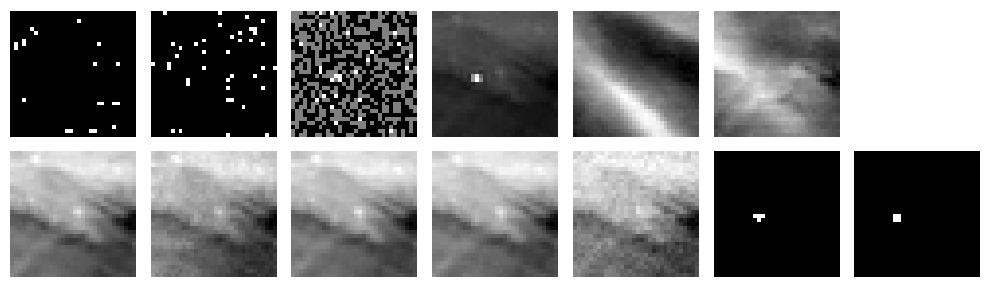

Index 8: Image torch.Size([11, 32, 32]), min/max: -0.49503931403160095/3.8168187141418457, Mask (1, 32, 32), min/max: 0.0/1.0


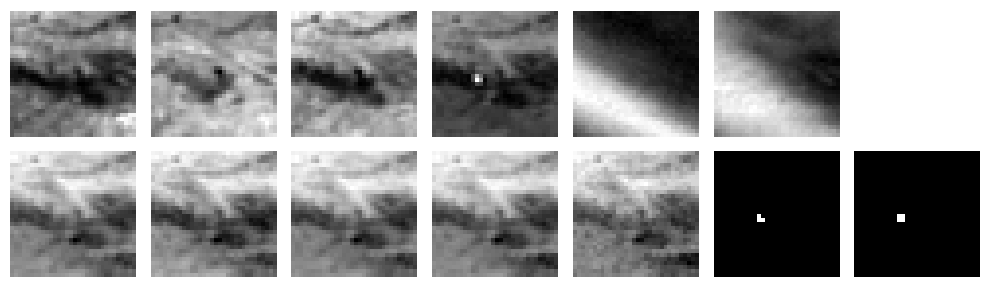

Index 9: Image torch.Size([11, 32, 32]), min/max: -0.5124704837799072/7.917398452758789, Mask (1, 32, 32), min/max: 0.0/1.0


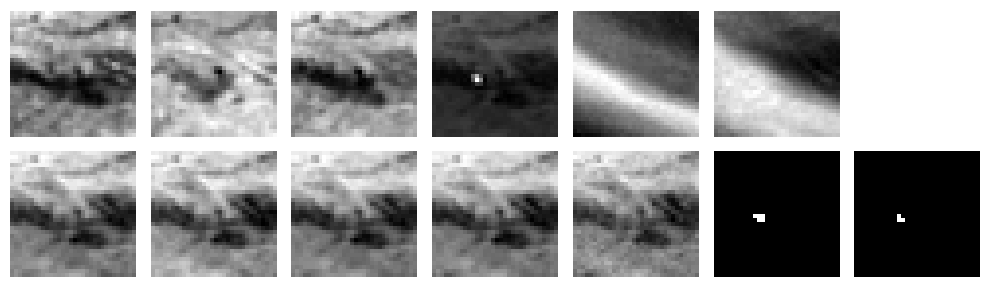

Index 10: Image torch.Size([11, 32, 32]), min/max: -0.6606365442276001/9.765044212341309, Mask (1, 32, 32), min/max: 0.0/1.0


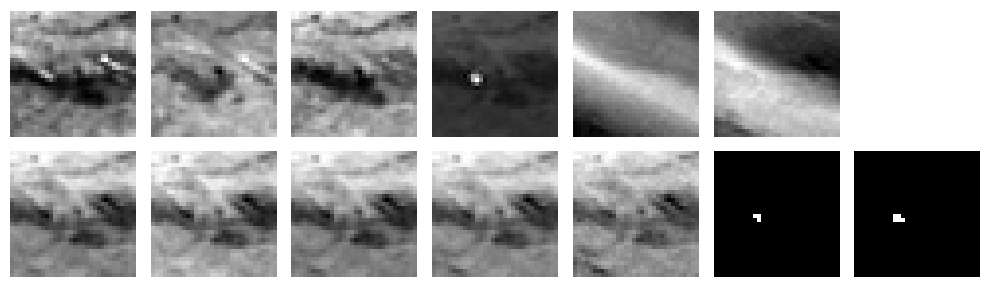

Index 11: Image torch.Size([11, 32, 32]), min/max: -0.765224277973175/9.562399864196777, Mask (1, 32, 32), min/max: 0.0/1.0


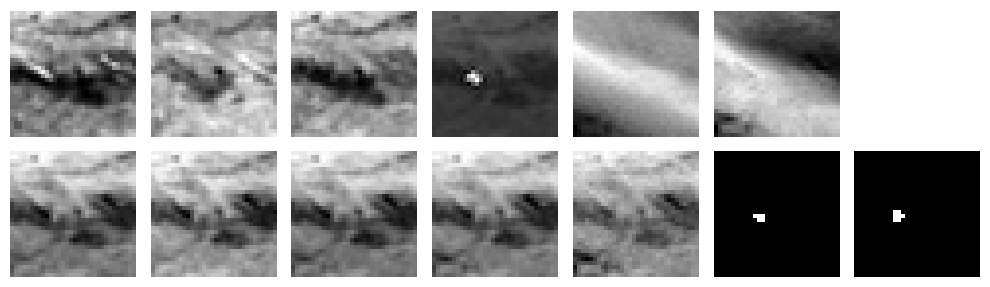

Index 12: Image torch.Size([11, 32, 32]), min/max: -1.4877114295959473/8.84718132019043, Mask (1, 32, 32), min/max: 0.0/1.0


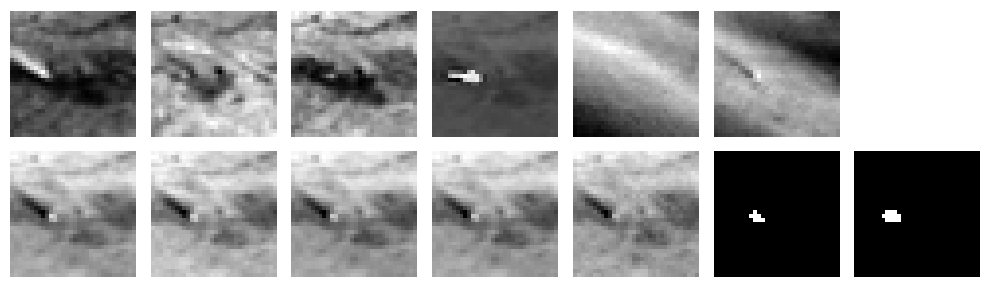

Index 13: Image torch.Size([11, 32, 32]), min/max: -2.309725761413574/7.452507972717285, Mask (1, 32, 32), min/max: 0.0/1.0


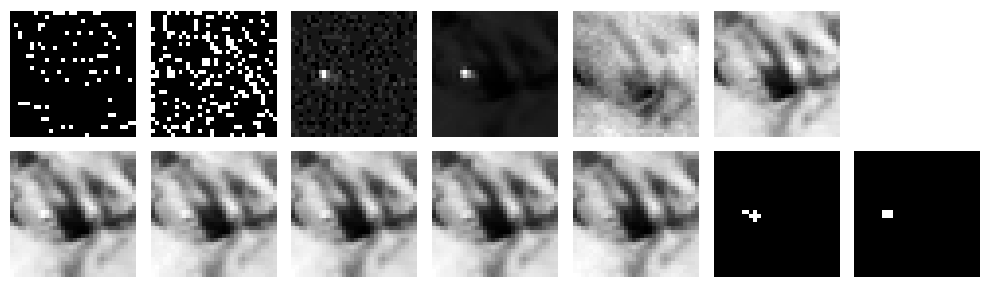

Index 14: Image torch.Size([11, 32, 32]), min/max: -1.8214795589447021/9.765044212341309, Mask (1, 32, 32), min/max: 0.0/1.0


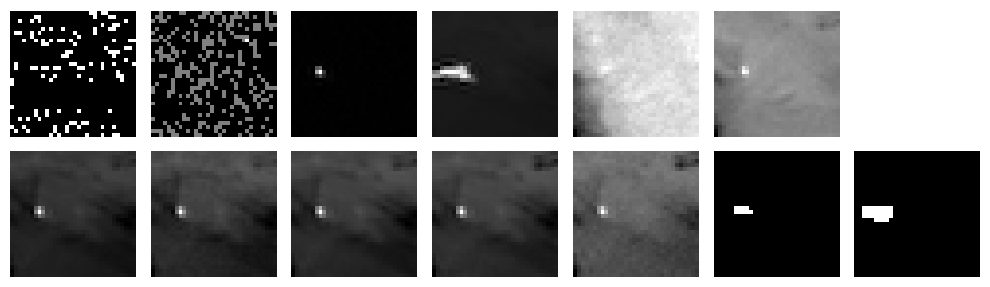

Index 15: Image torch.Size([11, 32, 32]), min/max: -1.8214795589447021/9.753124237060547, Mask (1, 32, 32), min/max: 0.0/1.0


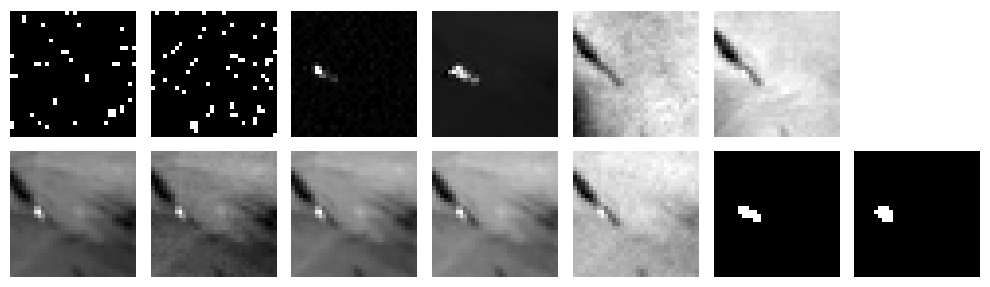

Index 16: Image torch.Size([11, 32, 32]), min/max: -1.7022767066955566/8.739898681640625, Mask (1, 32, 32), min/max: 0.0/1.0


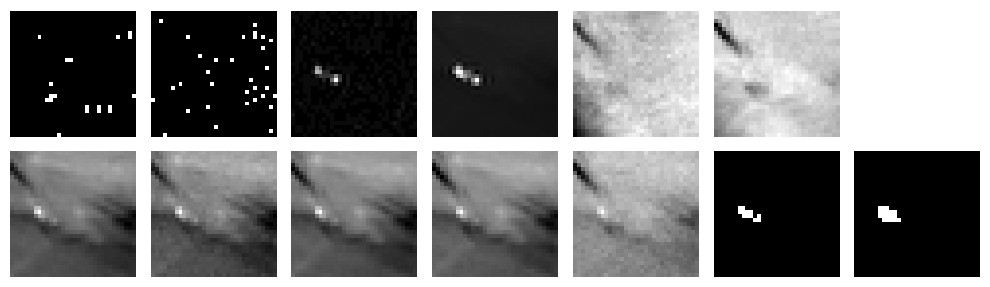

Index 17: Image torch.Size([11, 32, 32]), min/max: -1.0705012083053589/7.1545000076293945, Mask (1, 32, 32), min/max: 0.0/1.0


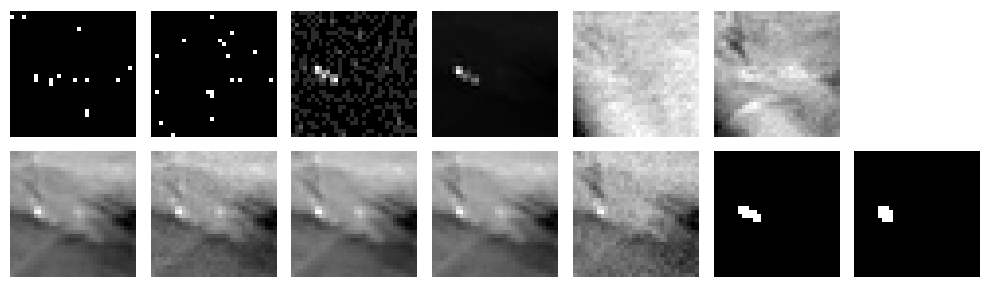

Index 18: Image torch.Size([11, 32, 32]), min/max: -0.41659829020500183/8.668377876281738, Mask (1, 32, 32), min/max: 0.0/1.0


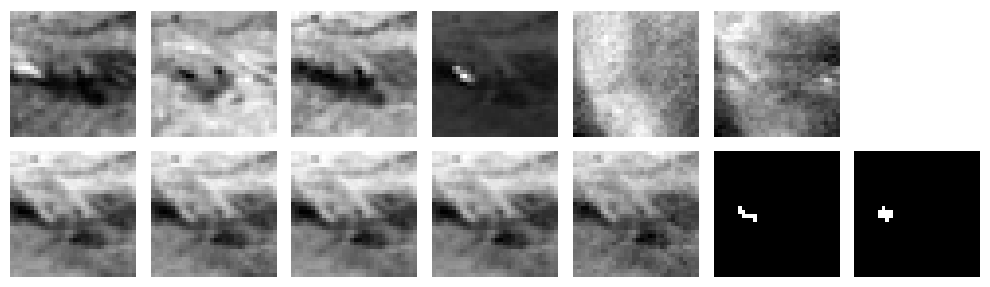

Index 19: Image torch.Size([11, 32, 32]), min/max: -0.3730201721191406/6.630007743835449, Mask (1, 32, 32), min/max: 0.0/1.0


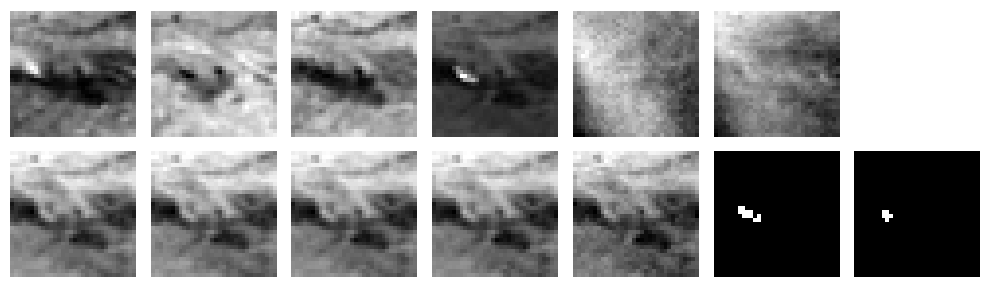

Index 20: Image torch.Size([11, 32, 32]), min/max: -0.26843249797821045/4.293630123138428, Mask (1, 32, 32), min/max: 0.0/1.0


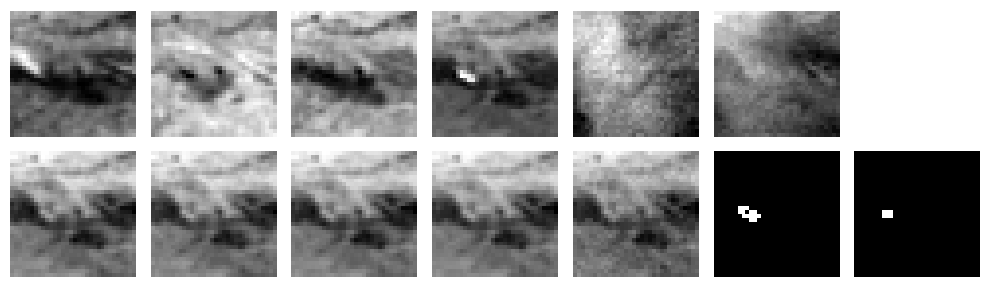

Index 21: Image torch.Size([11, 32, 32]), min/max: -0.2800237238407135/8.310769081115723, Mask (1, 32, 32), min/max: 0.0/1.0


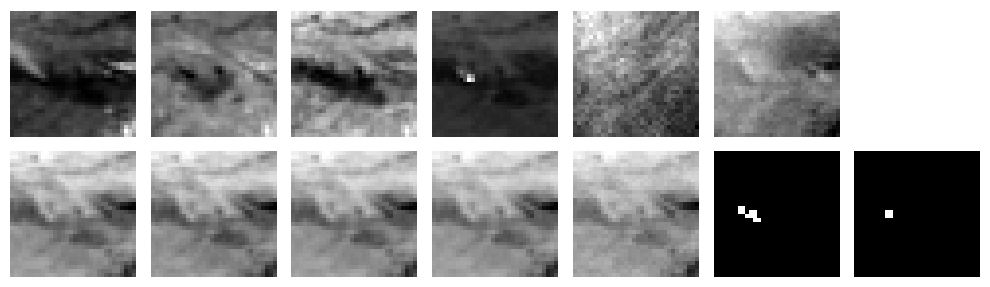

Index 22: Image torch.Size([11, 32, 32]), min/max: -2.2136361598968506/0.3135189116001129, Mask (1, 32, 32), min/max: 0.0/1.0


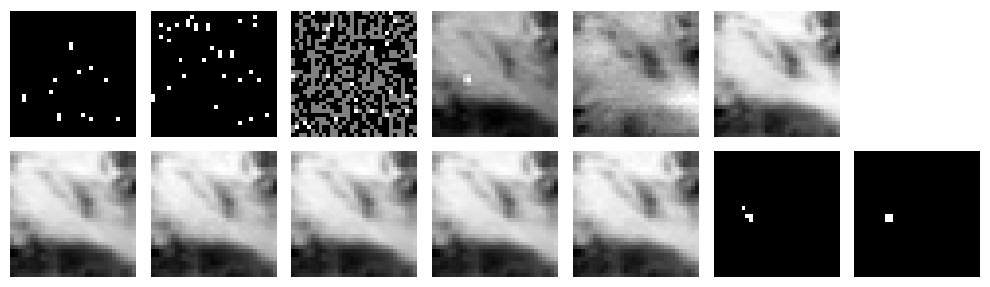

Index 23: Image torch.Size([11, 32, 32]), min/max: -2.751737594604492/6.299334526062012, Mask (1, 32, 32), min/max: 0.0/1.0


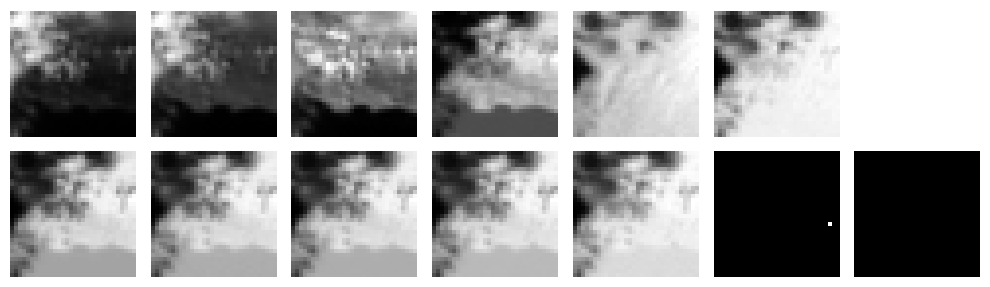

Index 24: Image torch.Size([11, 32, 32]), min/max: -0.6588909029960632/8.370369911193848, Mask (1, 32, 32), min/max: 0.0/1.0


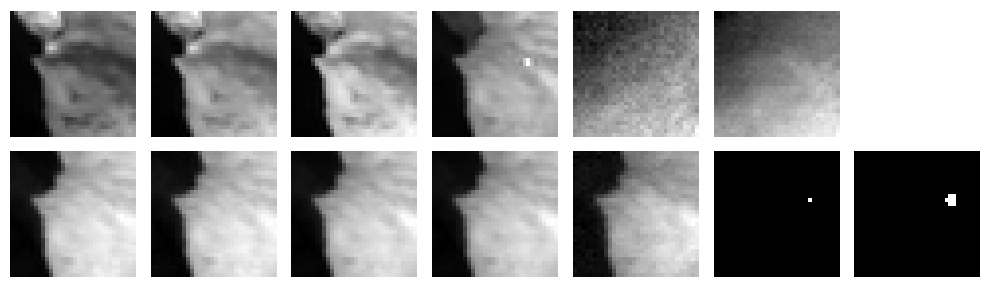

Index 25: Image torch.Size([11, 32, 32]), min/max: -0.6588909029960632/8.84718132019043, Mask (1, 32, 32), min/max: 0.0/1.0


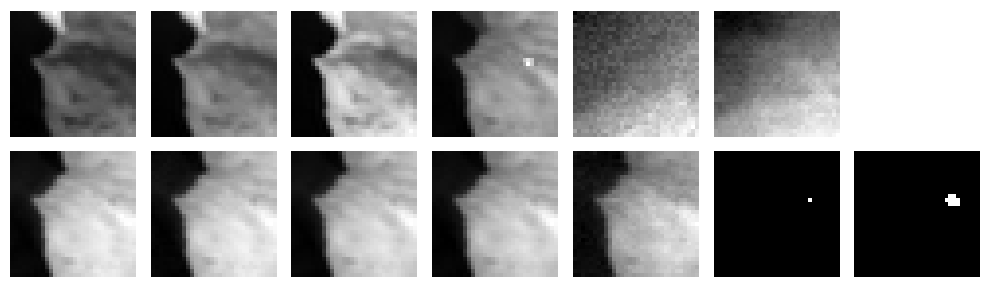

Index 26: Image torch.Size([11, 32, 32]), min/max: -2.5617175102233887/6.650755882263184, Mask (1, 32, 32), min/max: 0.0/1.0


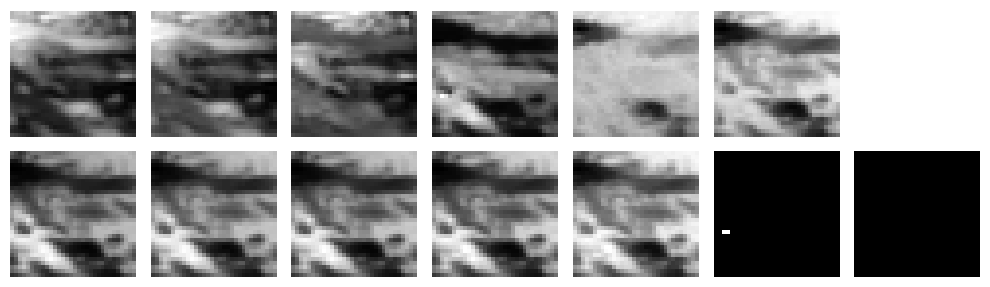

Index 27: Image torch.Size([11, 32, 32]), min/max: -0.6012905836105347/1.5792841911315918, Mask (1, 32, 32), min/max: 0.0/1.0


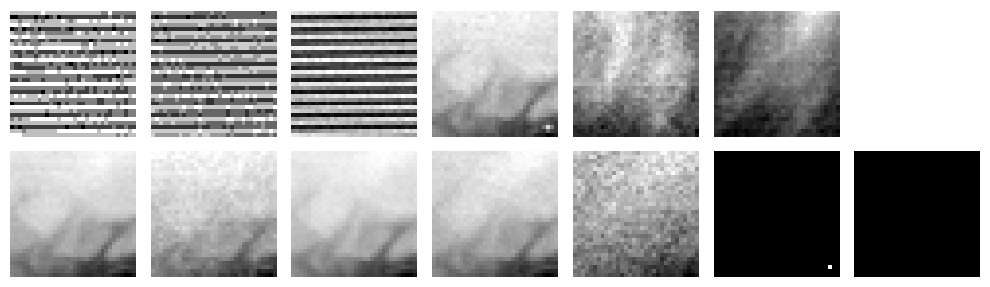

Index 28: Image torch.Size([11, 32, 32]), min/max: -0.7615295648574829/1.5269904136657715, Mask (1, 32, 32), min/max: 0.0/1.0


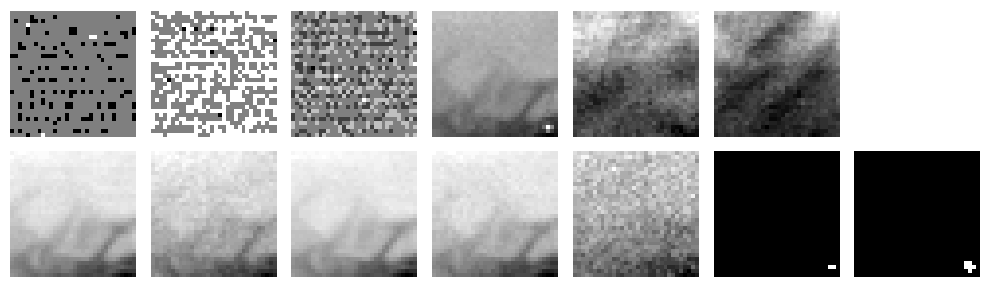

Index 29: Image torch.Size([11, 32, 32]), min/max: -0.7661347389221191/1.6054316759109497, Mask (1, 32, 32), min/max: 0.0/1.0


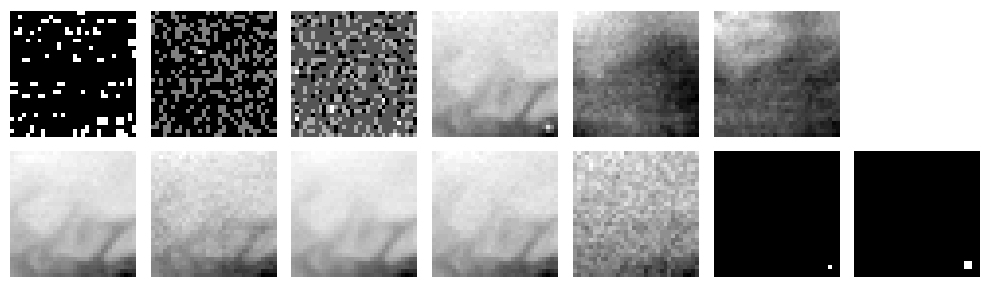

Index 30: Image torch.Size([11, 32, 32]), min/max: -0.6119397282600403/1.1385992765426636, Mask (1, 32, 32), min/max: 0.0/1.0


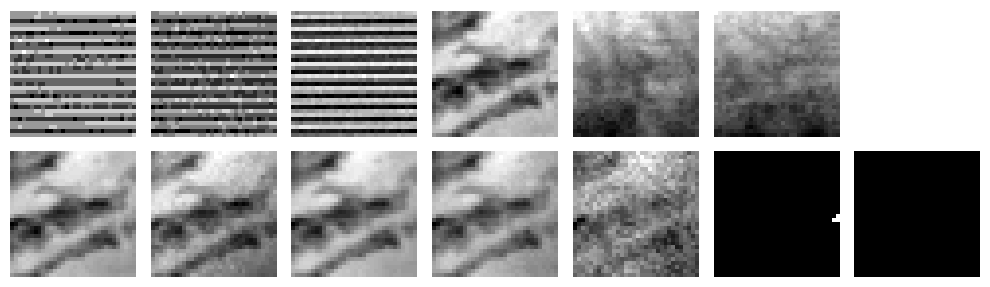

Index 31: Image torch.Size([11, 32, 32]), min/max: -0.6119397282600403/1.1209557056427002, Mask (1, 32, 32), min/max: 0.0/1.0


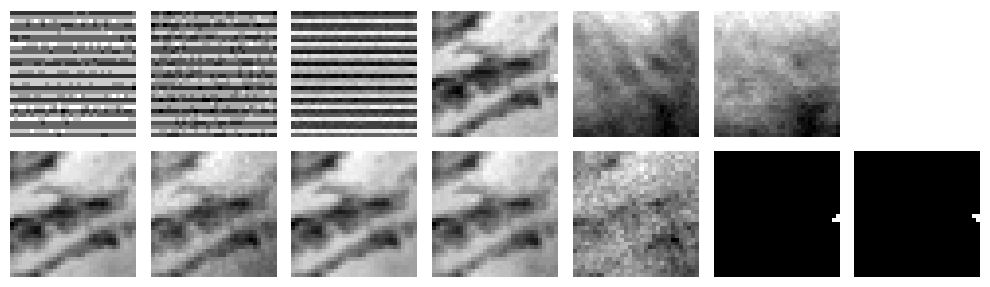

In [14]:
checkpoint_path = glob.glob(os.path.join(trainer.logger.log_dir, "checkpoints", "valid_loss*"))[0]

print(f"Loading checkpoint from: {checkpoint_path}...")
model = MSGAFModel.load_from_checkpoint(
    checkpoint_path, arch="Unet", encoder_name="resnet18", in_channels=11, out_classes=OUT_CLASSES, encoder_weights=None,
)

# Run validation dataset
valid_metrics = trainer.validate(
    model, dataloaders=msg_af_datamodule.val_dataloader(), verbose=False
)
all_valid_metrics.append(valid_metrics)
print("Validation results:", {k: round(v, 4) for k, v in valid_metrics[0].items()})

# Run test dataset
test_metrics = trainer.test(
    model, dataloaders=msg_af_datamodule.test_dataloader(), verbose=False
)
all_test_metrics.append(test_metrics)
print("Test results:", {k: round(v, 4) for k, v in test_metrics[0].items()})

print("Visualize predictions:")
visualize_predictions(msg_af_datamodule.test_dataset, range(32), model)

Loading checkpoint from: /home/jupyter-kalexis/and_project_private/and_representation-learning-baselines/fire_fm/lightning_logs/version_0/checkpoints/valid_balanced_acc=0.783-epoch=54-step=1815.ckpt...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation results: {'valid_loss': 0.3005, 'valid_acc_micro': 0.9954, 'valid_balanced_acc': 0.7825, 'valid_iou_micro': 0.9909, 'valid_iou0': 0.9954, 'valid_iou1': 0.2888, 'valid_precision0': 0.9986, 'valid_precision1': 0.37, 'valid_recall0': 0.9968, 'valid_recall1': 0.5682}


Testing: |          | 0/? [00:00<?, ?it/s]

Test results: {'test_loss': 0.3401, 'test_acc_micro': 0.9953, 'test_balanced_acc': 0.6967, 'test_iou_micro': 0.9905, 'test_iou0': 0.9952, 'test_iou1': 0.2397, 'test_precision0': 0.9977, 'test_precision1': 0.3778, 'test_recall0': 0.9975, 'test_recall1': 0.3959}
Visualize predictions:
Index 0: Image torch.Size([11, 32, 32]), min/max: -2.5787763595581055/4.531582355499268, Mask (1, 32, 32), min/max: 0.0/1.0


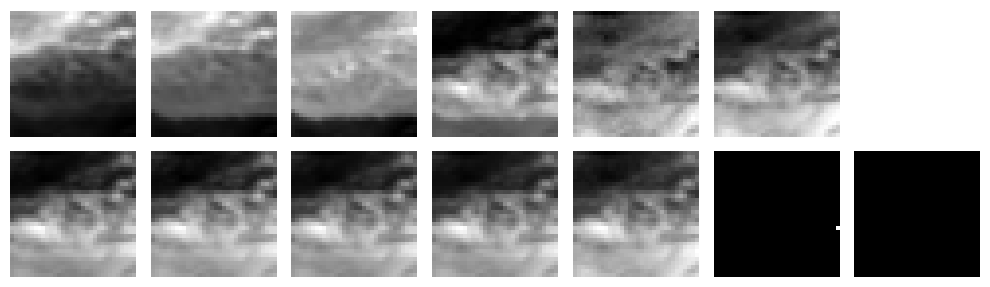

Index 1: Image torch.Size([11, 32, 32]), min/max: -0.9743996262550354/7.237942218780518, Mask (1, 32, 32), min/max: 0.0/1.0


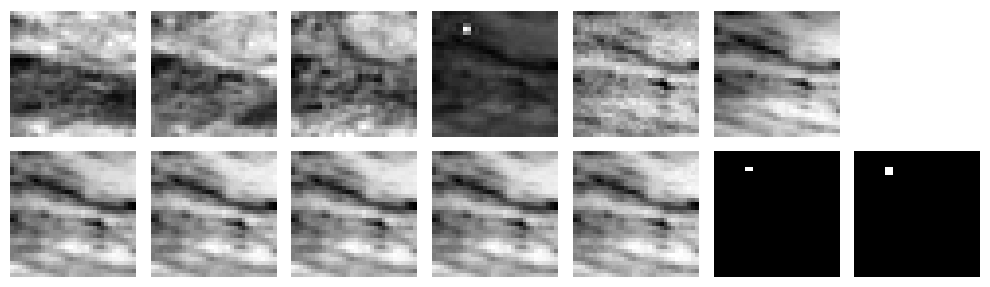

Index 2: Image torch.Size([11, 32, 32]), min/max: -1.0789875984191895/5.116130828857422, Mask (1, 32, 32), min/max: 0.0/1.0


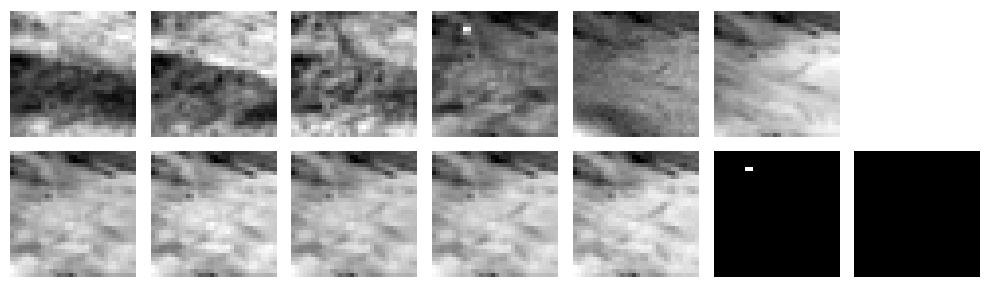

Index 3: Image torch.Size([11, 32, 32]), min/max: -1.7427973747253418/3.6618547439575195, Mask (1, 32, 32), min/max: 0.0/1.0


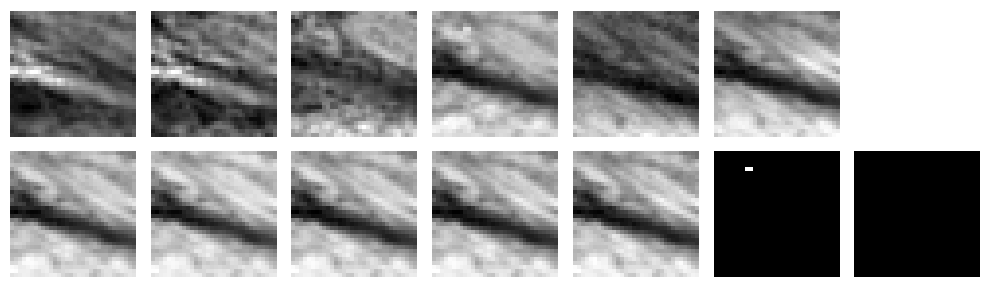

Index 4: Image torch.Size([11, 32, 32]), min/max: -1.4161896705627441/6.558485507965088, Mask (1, 32, 32), min/max: 0.0/1.0


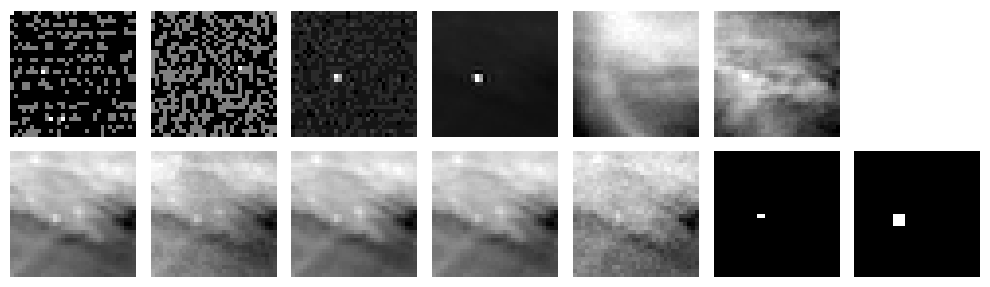

Index 5: Image torch.Size([11, 32, 32]), min/max: -1.0585808753967285/3.947941780090332, Mask (1, 32, 32), min/max: 0.0/1.0


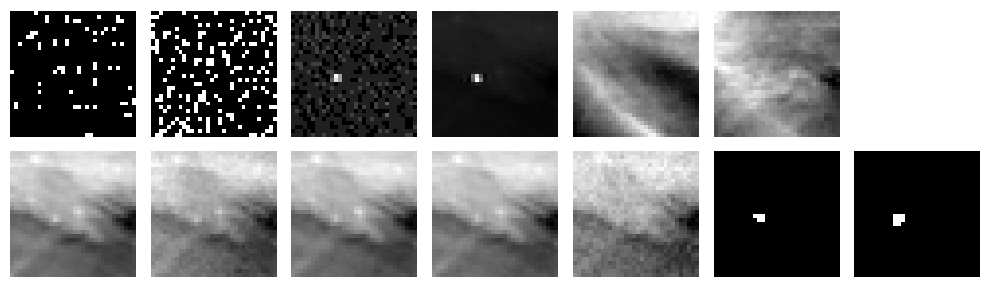

Index 6: Image torch.Size([11, 32, 32]), min/max: -1.0705012083053589/2.386383533477783, Mask (1, 32, 32), min/max: 0.0/1.0


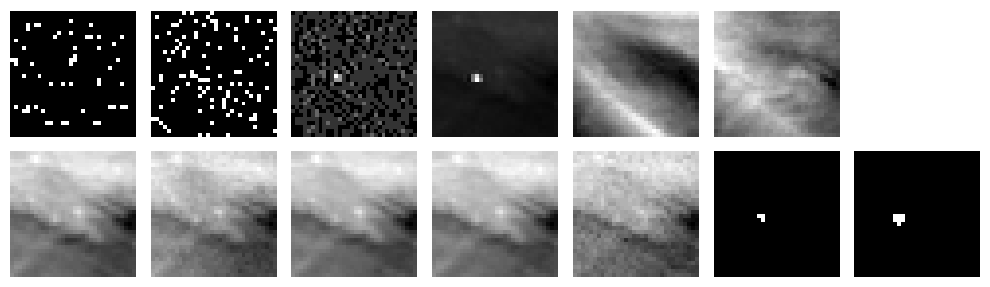

Index 7: Image torch.Size([11, 32, 32]), min/max: -1.0824214220046997/1.2393742799758911, Mask (1, 32, 32), min/max: 0.0/1.0


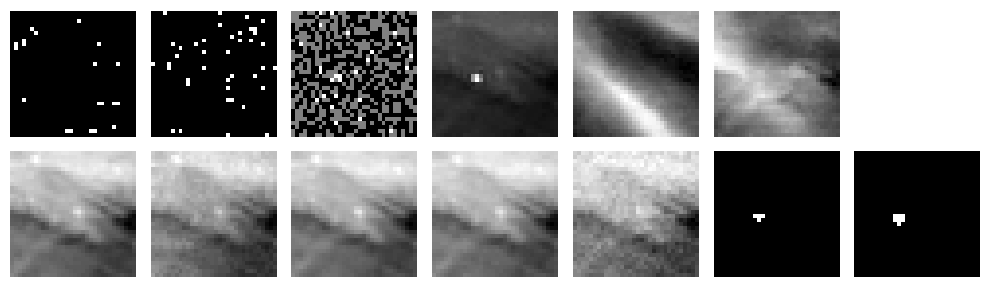

Index 8: Image torch.Size([11, 32, 32]), min/max: -0.49503931403160095/3.8168187141418457, Mask (1, 32, 32), min/max: 0.0/1.0


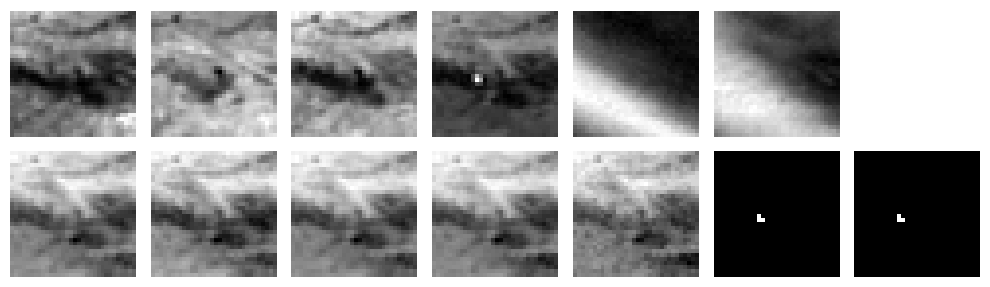

Index 9: Image torch.Size([11, 32, 32]), min/max: -0.5124704837799072/7.917398452758789, Mask (1, 32, 32), min/max: 0.0/1.0


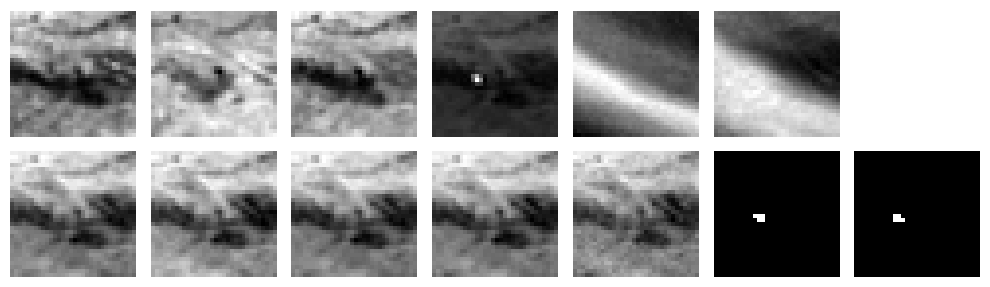

Index 10: Image torch.Size([11, 32, 32]), min/max: -0.6606365442276001/9.765044212341309, Mask (1, 32, 32), min/max: 0.0/1.0


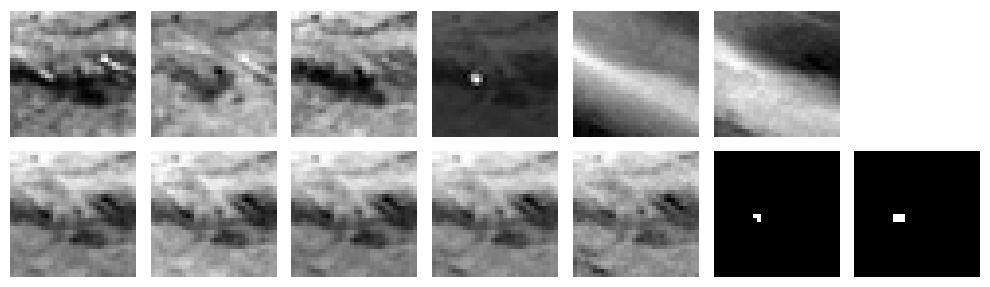

Index 11: Image torch.Size([11, 32, 32]), min/max: -0.765224277973175/9.562399864196777, Mask (1, 32, 32), min/max: 0.0/1.0


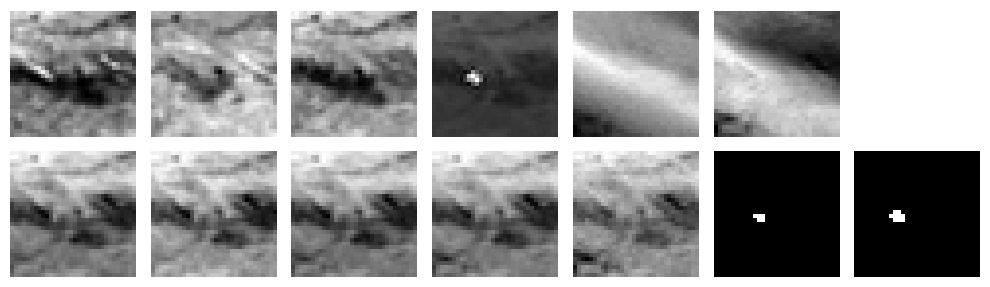

Index 12: Image torch.Size([11, 32, 32]), min/max: -1.4877114295959473/8.84718132019043, Mask (1, 32, 32), min/max: 0.0/1.0


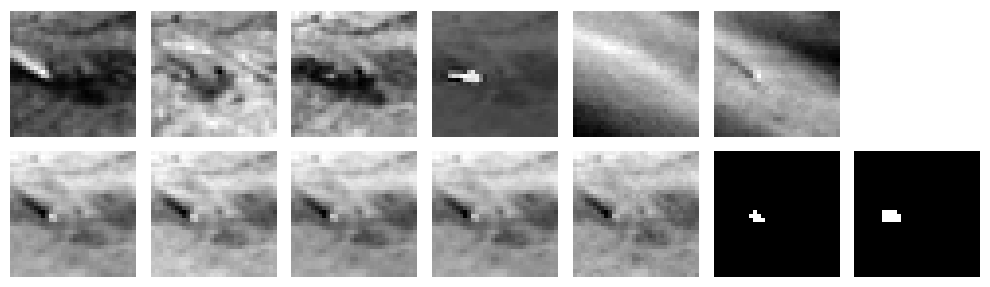

Index 13: Image torch.Size([11, 32, 32]), min/max: -2.309725761413574/7.452507972717285, Mask (1, 32, 32), min/max: 0.0/1.0


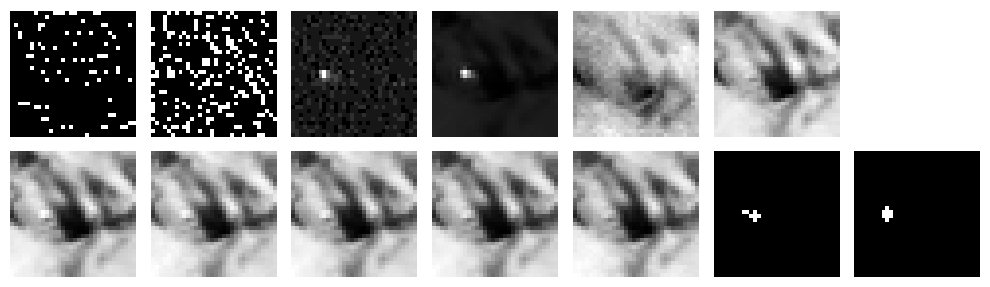

Index 14: Image torch.Size([11, 32, 32]), min/max: -1.8214795589447021/9.765044212341309, Mask (1, 32, 32), min/max: 0.0/1.0


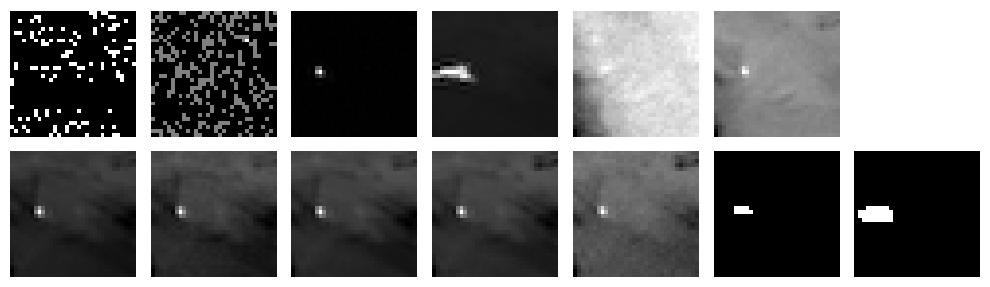

Index 15: Image torch.Size([11, 32, 32]), min/max: -1.8214795589447021/9.753124237060547, Mask (1, 32, 32), min/max: 0.0/1.0


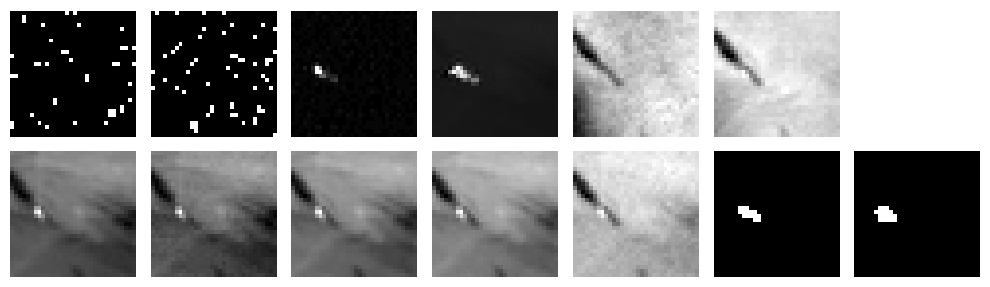

Index 16: Image torch.Size([11, 32, 32]), min/max: -1.7022767066955566/8.739898681640625, Mask (1, 32, 32), min/max: 0.0/1.0


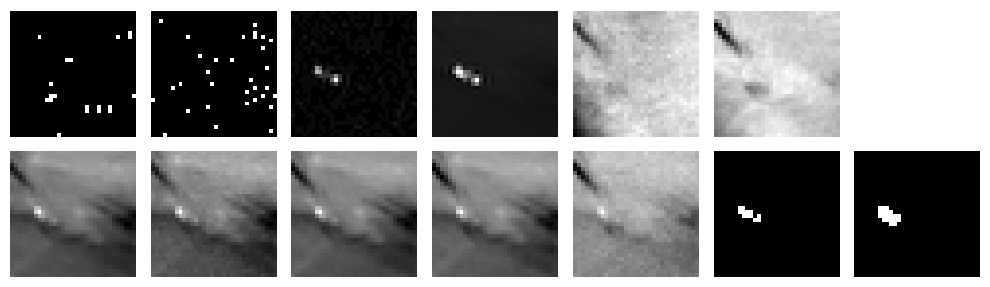

Index 17: Image torch.Size([11, 32, 32]), min/max: -1.0705012083053589/7.1545000076293945, Mask (1, 32, 32), min/max: 0.0/1.0


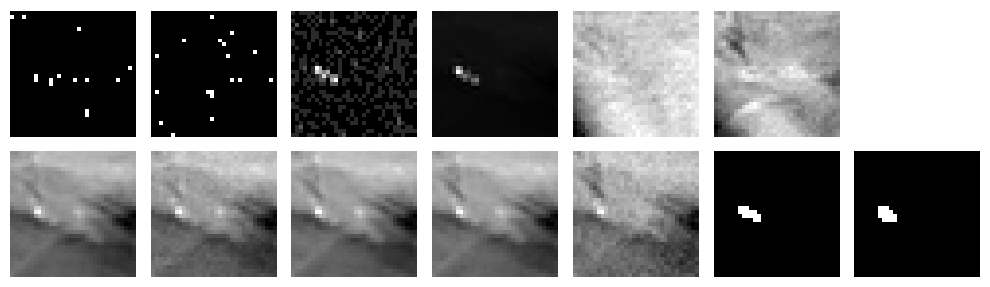

Index 18: Image torch.Size([11, 32, 32]), min/max: -0.41659829020500183/8.668377876281738, Mask (1, 32, 32), min/max: 0.0/1.0


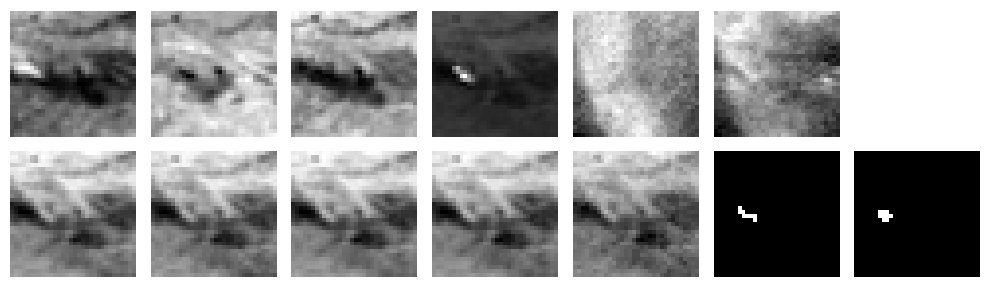

Index 19: Image torch.Size([11, 32, 32]), min/max: -0.3730201721191406/6.630007743835449, Mask (1, 32, 32), min/max: 0.0/1.0


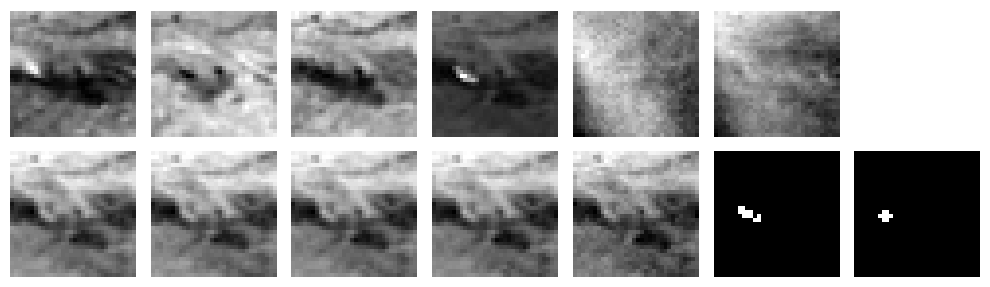

Index 20: Image torch.Size([11, 32, 32]), min/max: -0.26843249797821045/4.293630123138428, Mask (1, 32, 32), min/max: 0.0/1.0


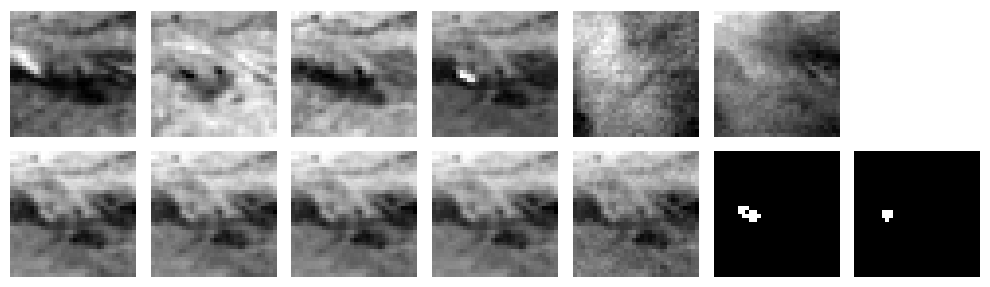

Index 21: Image torch.Size([11, 32, 32]), min/max: -0.2800237238407135/8.310769081115723, Mask (1, 32, 32), min/max: 0.0/1.0


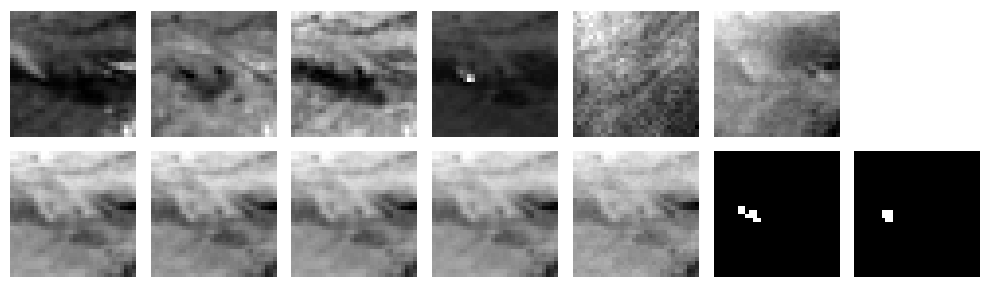

Index 22: Image torch.Size([11, 32, 32]), min/max: -2.2136361598968506/0.3135189116001129, Mask (1, 32, 32), min/max: 0.0/1.0


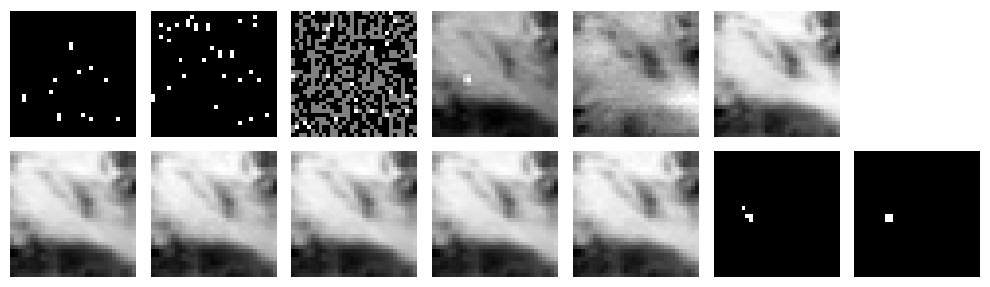

Index 23: Image torch.Size([11, 32, 32]), min/max: -2.751737594604492/6.299334526062012, Mask (1, 32, 32), min/max: 0.0/1.0


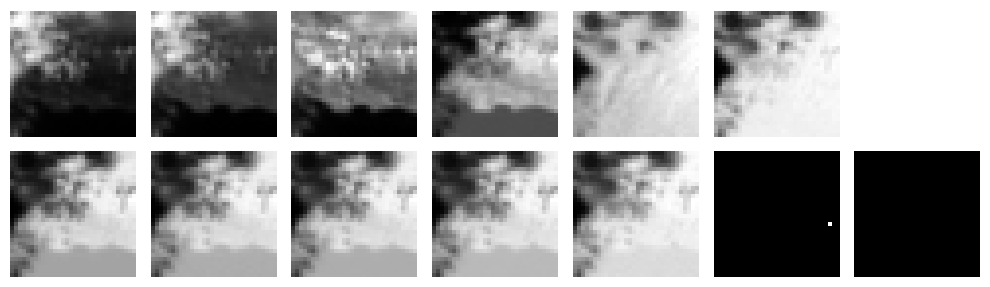

Index 24: Image torch.Size([11, 32, 32]), min/max: -0.6588909029960632/8.370369911193848, Mask (1, 32, 32), min/max: 0.0/1.0


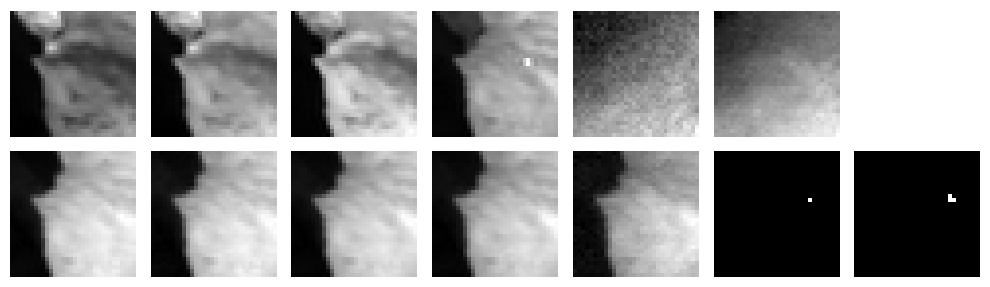

Index 25: Image torch.Size([11, 32, 32]), min/max: -0.6588909029960632/8.84718132019043, Mask (1, 32, 32), min/max: 0.0/1.0


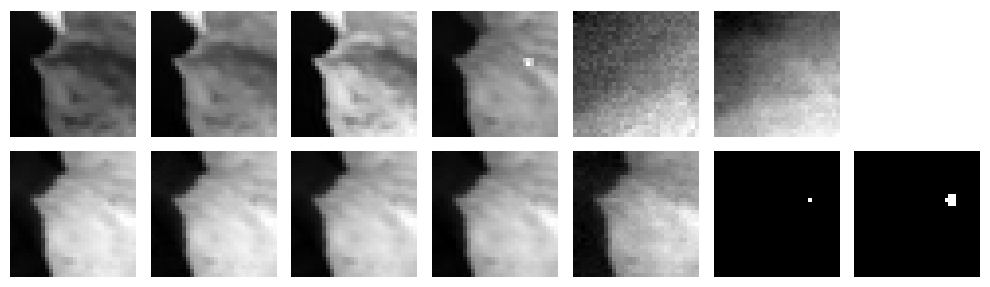

Index 26: Image torch.Size([11, 32, 32]), min/max: -2.5617175102233887/6.650755882263184, Mask (1, 32, 32), min/max: 0.0/1.0


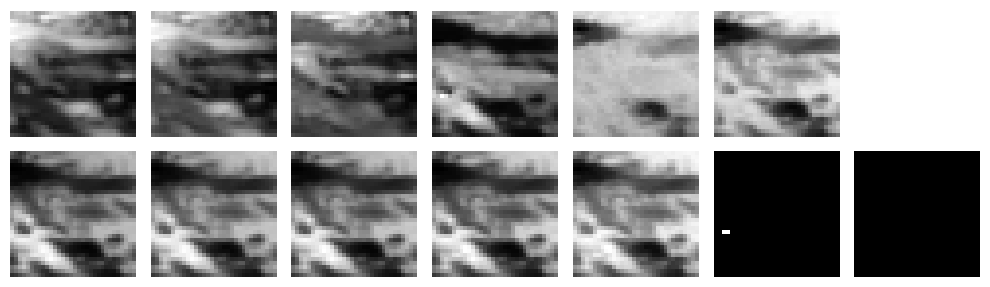

Index 27: Image torch.Size([11, 32, 32]), min/max: -0.6012905836105347/1.5792841911315918, Mask (1, 32, 32), min/max: 0.0/1.0


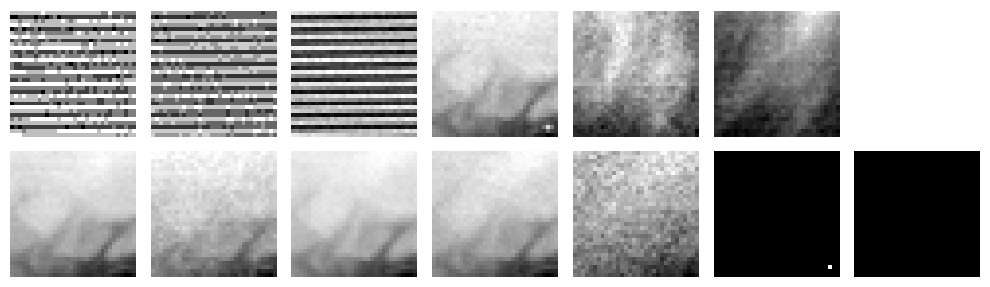

Index 28: Image torch.Size([11, 32, 32]), min/max: -0.7615295648574829/1.5269904136657715, Mask (1, 32, 32), min/max: 0.0/1.0


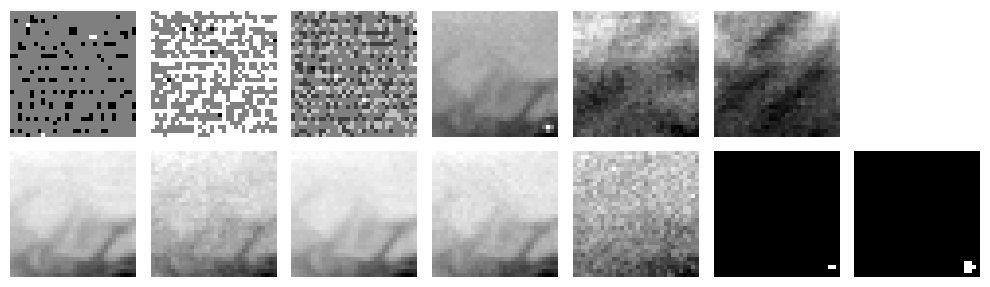

Index 29: Image torch.Size([11, 32, 32]), min/max: -0.7661347389221191/1.6054316759109497, Mask (1, 32, 32), min/max: 0.0/1.0


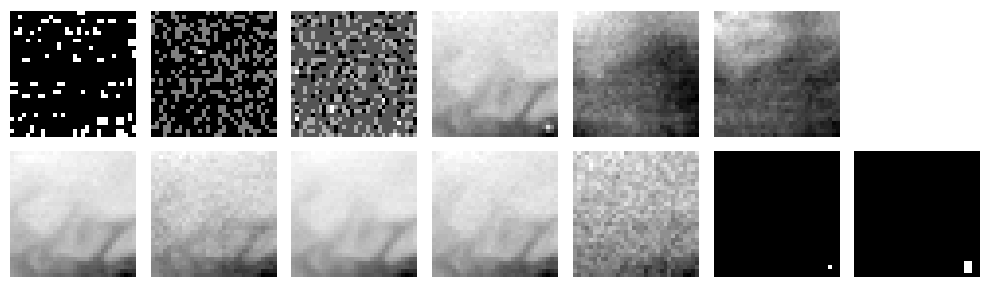

Index 30: Image torch.Size([11, 32, 32]), min/max: -0.6119397282600403/1.1385992765426636, Mask (1, 32, 32), min/max: 0.0/1.0


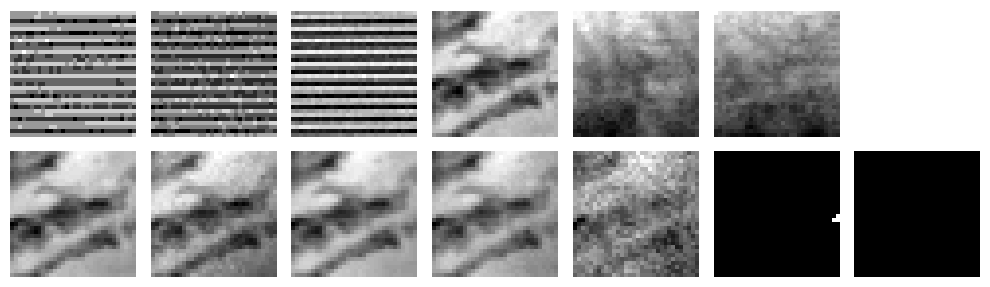

Index 31: Image torch.Size([11, 32, 32]), min/max: -0.6119397282600403/1.1209557056427002, Mask (1, 32, 32), min/max: 0.0/1.0


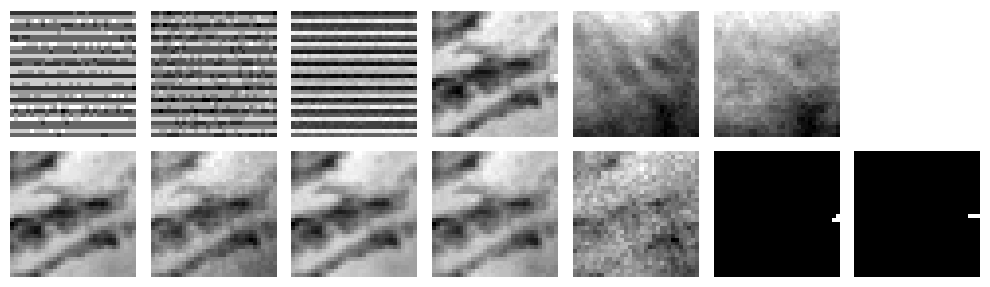

In [15]:
checkpoint_path = glob.glob(os.path.join(trainer.logger.log_dir, "checkpoints", "valid_balanced_acc*"))[0]

print(f"Loading checkpoint from: {checkpoint_path}...")
model = MSGAFModel.load_from_checkpoint(
    checkpoint_path, arch="Unet", encoder_name="resnet18", in_channels=11, out_classes=OUT_CLASSES, encoder_weights=None,
)

# Run validation dataset
valid_metrics = trainer.validate(
    model, dataloaders=msg_af_datamodule.val_dataloader(), verbose=False
)
all_valid_metrics.append(valid_metrics)
print("Validation results:", {k: round(v, 4) for k, v in valid_metrics[0].items()})

# Run test dataset
test_metrics = trainer.test(
    model, dataloaders=msg_af_datamodule.test_dataloader(), verbose=False
)
all_test_metrics.append(test_metrics)
print("Test results:", {k: round(v, 4) for k, v in test_metrics[0].items()})

print("Visualize predictions:")
visualize_predictions(msg_af_datamodule.test_dataset, range(32), model)

Loading checkpoint from: /home/jupyter-kalexis/and_project_private/and_representation-learning-baselines/fire_fm/lightning_logs/version_0/checkpoints/valid_iou1=0.334-epoch=73-step=2442.ckpt...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation results: {'valid_loss': 0.2762, 'valid_acc_micro': 0.9964, 'valid_balanced_acc': 0.7721, 'valid_iou_micro': 0.9929, 'valid_iou0': 0.9964, 'valid_iou1': 0.3344, 'valid_precision0': 0.9985, 'valid_precision1': 0.4631, 'valid_recall0': 0.9979, 'valid_recall1': 0.5463}


Testing: |          | 0/? [00:00<?, ?it/s]

Test results: {'test_loss': 0.3324, 'test_acc_micro': 0.9961, 'test_balanced_acc': 0.6784, 'test_iou_micro': 0.9921, 'test_iou0': 0.996, 'test_iou1': 0.2556, 'test_precision0': 0.9976, 'test_precision1': 0.4712, 'test_recall0': 0.9985, 'test_recall1': 0.3584}
Visualize predictions:
Index 0: Image torch.Size([11, 32, 32]), min/max: -2.5787763595581055/4.531582355499268, Mask (1, 32, 32), min/max: 0.0/1.0


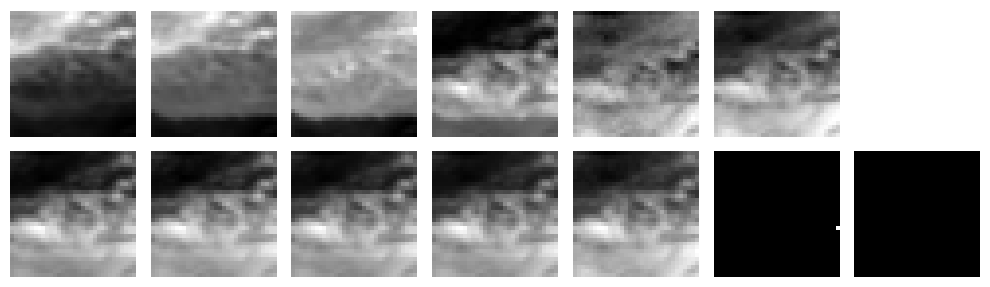

Index 1: Image torch.Size([11, 32, 32]), min/max: -0.9743996262550354/7.237942218780518, Mask (1, 32, 32), min/max: 0.0/1.0


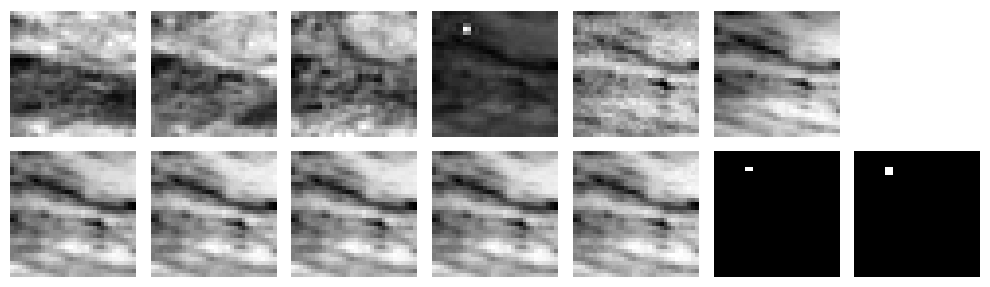

Index 2: Image torch.Size([11, 32, 32]), min/max: -1.0789875984191895/5.116130828857422, Mask (1, 32, 32), min/max: 0.0/1.0


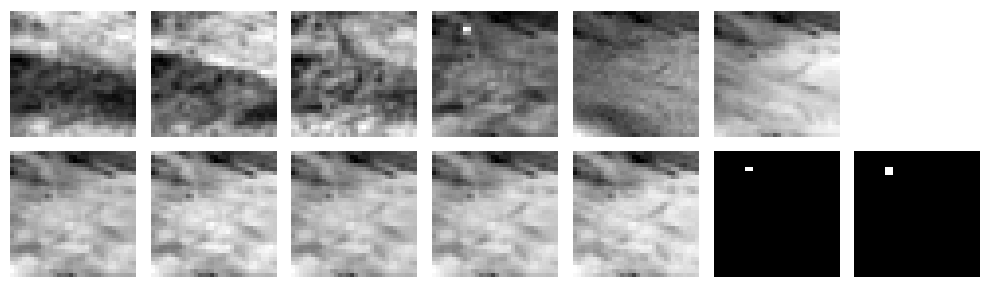

Index 3: Image torch.Size([11, 32, 32]), min/max: -1.7427973747253418/3.6618547439575195, Mask (1, 32, 32), min/max: 0.0/1.0


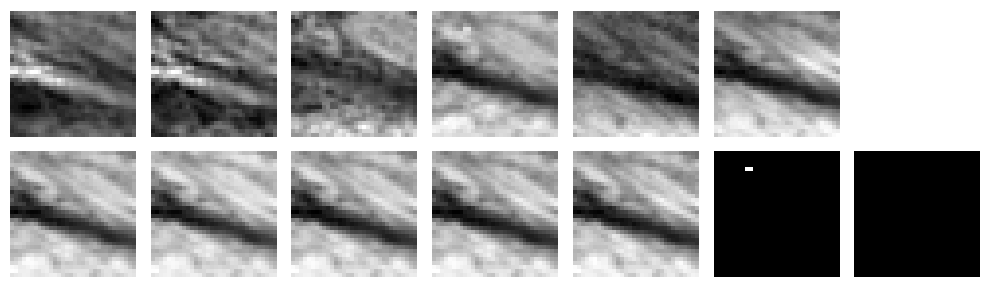

Index 4: Image torch.Size([11, 32, 32]), min/max: -1.4161896705627441/6.558485507965088, Mask (1, 32, 32), min/max: 0.0/1.0


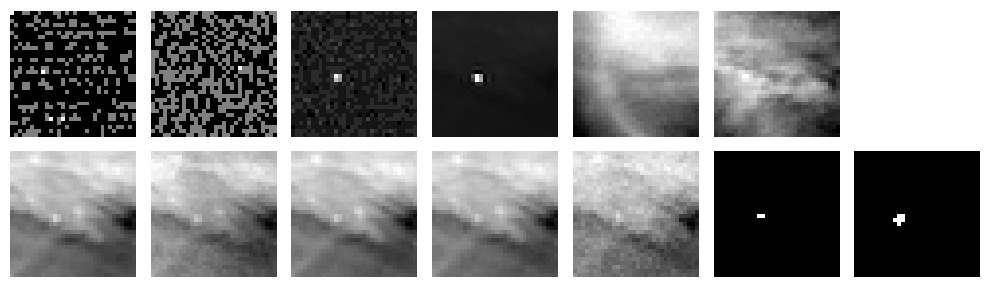

Index 5: Image torch.Size([11, 32, 32]), min/max: -1.0585808753967285/3.947941780090332, Mask (1, 32, 32), min/max: 0.0/1.0


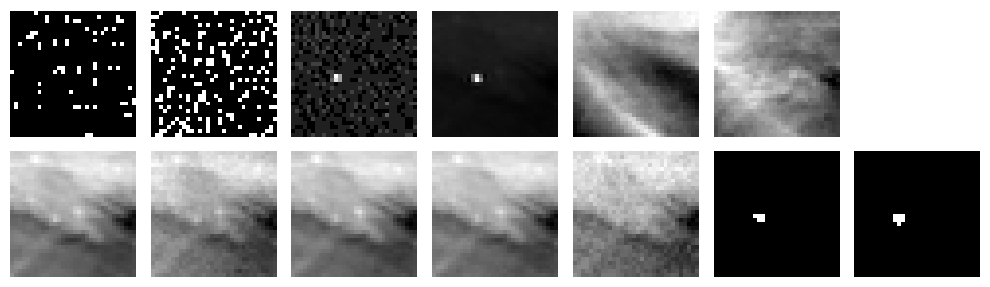

Index 6: Image torch.Size([11, 32, 32]), min/max: -1.0705012083053589/2.386383533477783, Mask (1, 32, 32), min/max: 0.0/1.0


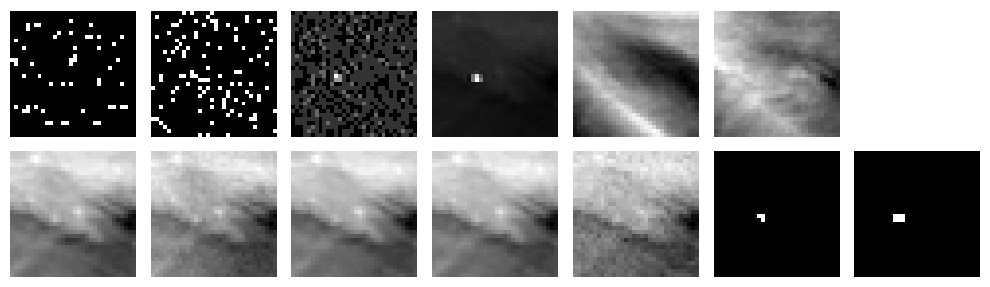

Index 7: Image torch.Size([11, 32, 32]), min/max: -1.0824214220046997/1.2393742799758911, Mask (1, 32, 32), min/max: 0.0/1.0


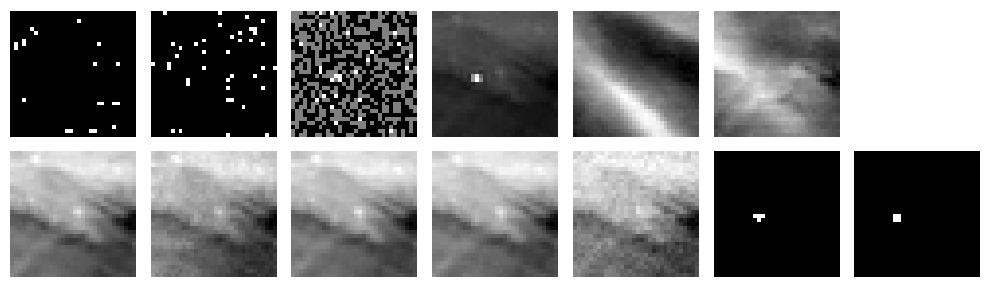

Index 8: Image torch.Size([11, 32, 32]), min/max: -0.49503931403160095/3.8168187141418457, Mask (1, 32, 32), min/max: 0.0/1.0


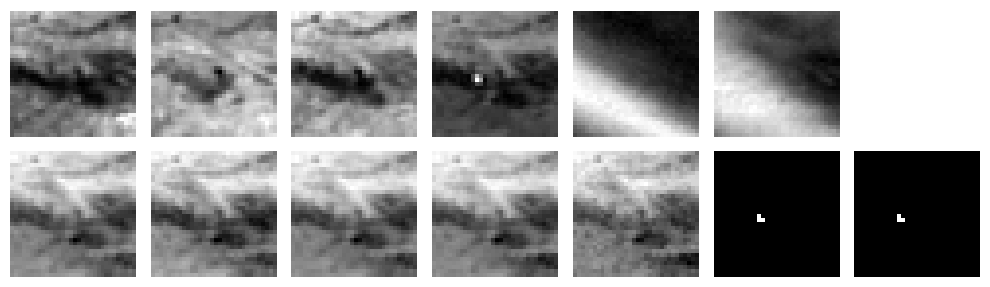

Index 9: Image torch.Size([11, 32, 32]), min/max: -0.5124704837799072/7.917398452758789, Mask (1, 32, 32), min/max: 0.0/1.0


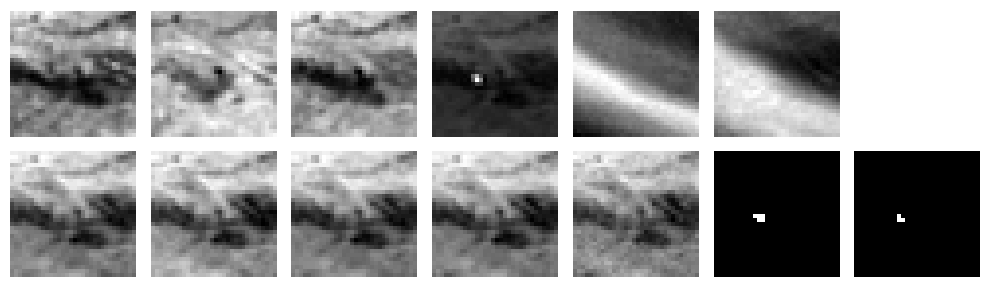

Index 10: Image torch.Size([11, 32, 32]), min/max: -0.6606365442276001/9.765044212341309, Mask (1, 32, 32), min/max: 0.0/1.0


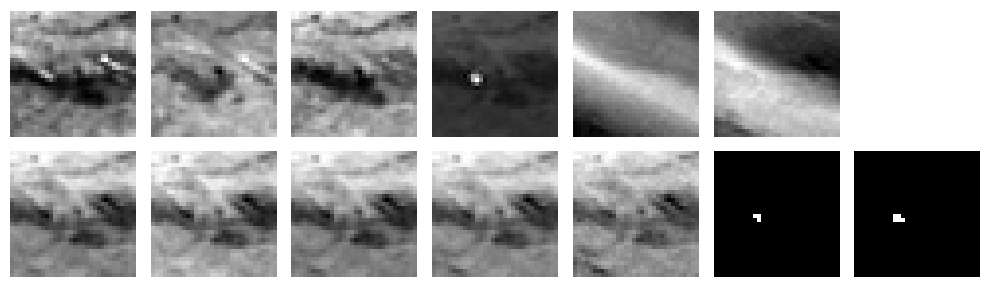

Index 11: Image torch.Size([11, 32, 32]), min/max: -0.765224277973175/9.562399864196777, Mask (1, 32, 32), min/max: 0.0/1.0


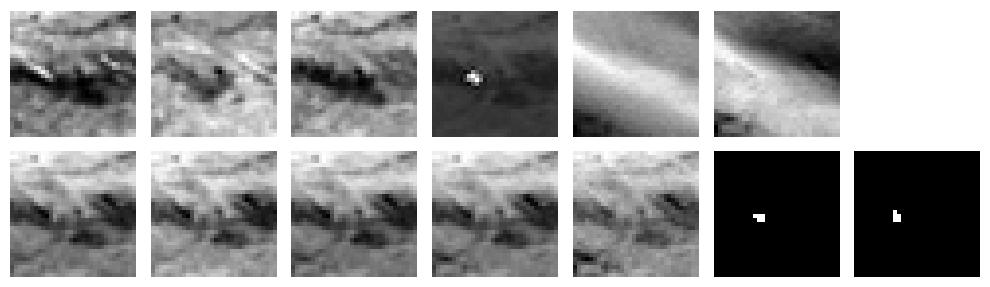

Index 12: Image torch.Size([11, 32, 32]), min/max: -1.4877114295959473/8.84718132019043, Mask (1, 32, 32), min/max: 0.0/1.0


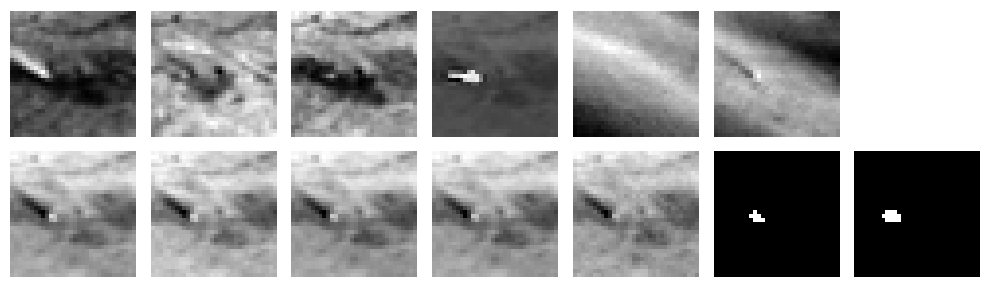

Index 13: Image torch.Size([11, 32, 32]), min/max: -2.309725761413574/7.452507972717285, Mask (1, 32, 32), min/max: 0.0/1.0


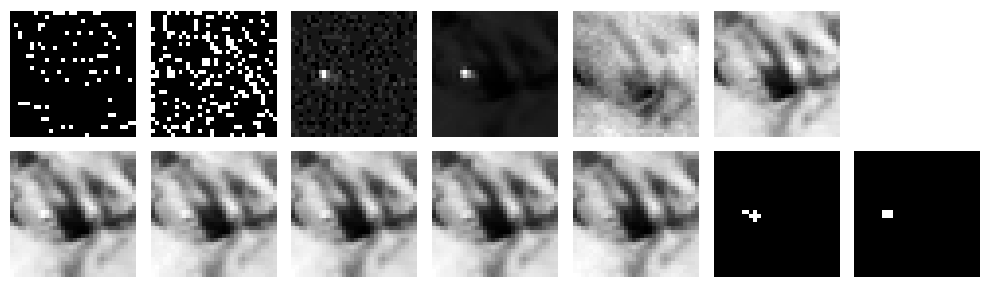

Index 14: Image torch.Size([11, 32, 32]), min/max: -1.8214795589447021/9.765044212341309, Mask (1, 32, 32), min/max: 0.0/1.0


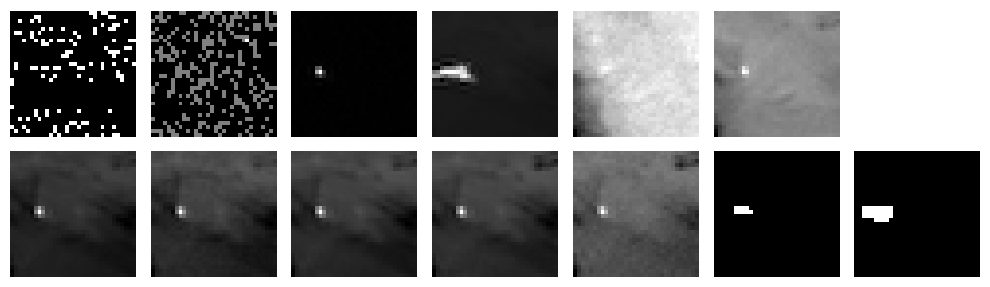

Index 15: Image torch.Size([11, 32, 32]), min/max: -1.8214795589447021/9.753124237060547, Mask (1, 32, 32), min/max: 0.0/1.0


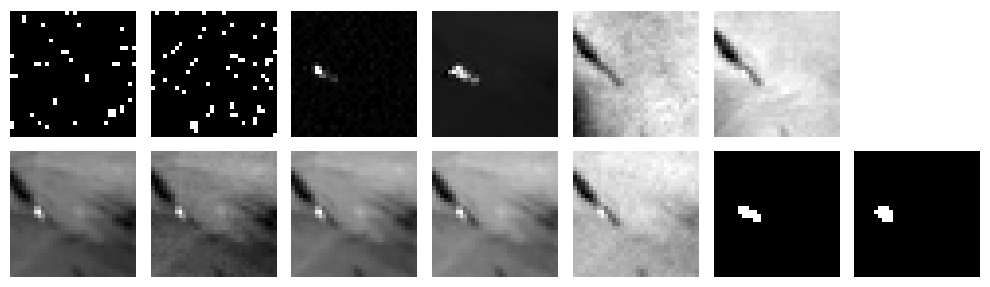

Index 16: Image torch.Size([11, 32, 32]), min/max: -1.7022767066955566/8.739898681640625, Mask (1, 32, 32), min/max: 0.0/1.0


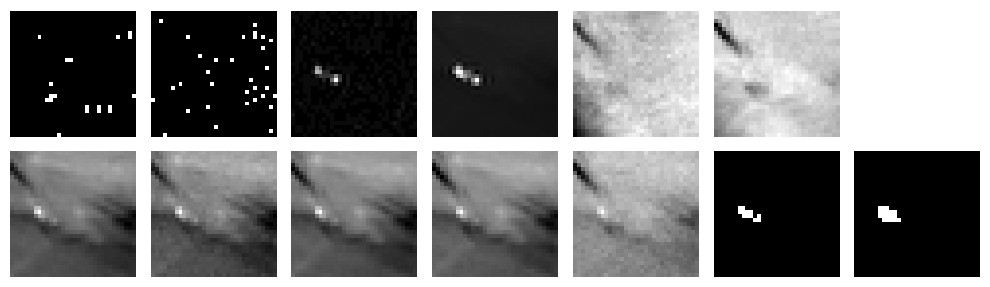

Index 17: Image torch.Size([11, 32, 32]), min/max: -1.0705012083053589/7.1545000076293945, Mask (1, 32, 32), min/max: 0.0/1.0


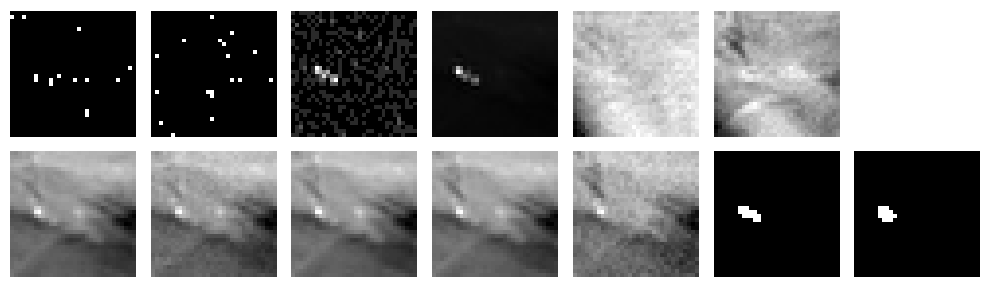

Index 18: Image torch.Size([11, 32, 32]), min/max: -0.41659829020500183/8.668377876281738, Mask (1, 32, 32), min/max: 0.0/1.0


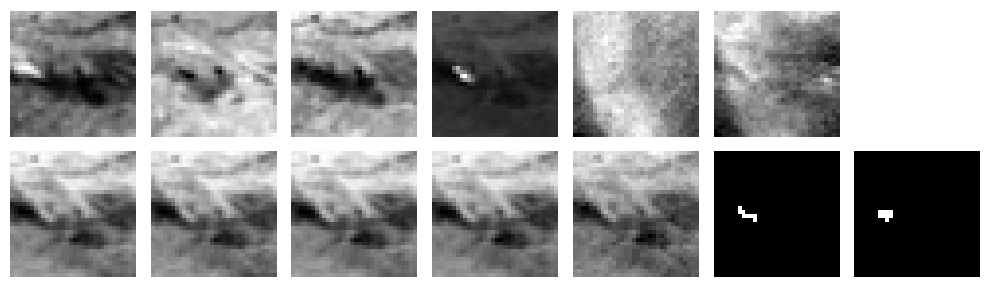

Index 19: Image torch.Size([11, 32, 32]), min/max: -0.3730201721191406/6.630007743835449, Mask (1, 32, 32), min/max: 0.0/1.0


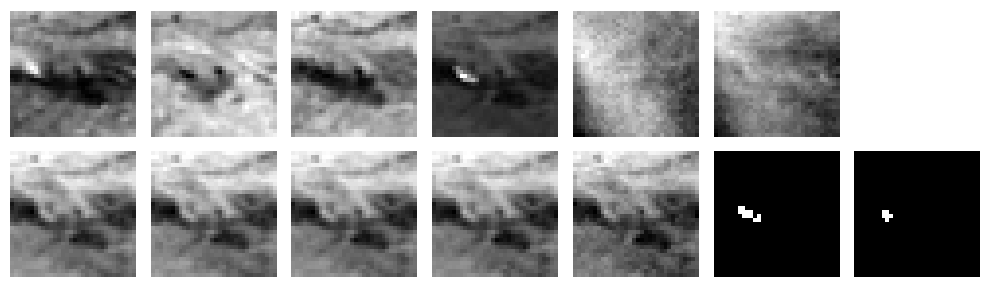

Index 20: Image torch.Size([11, 32, 32]), min/max: -0.26843249797821045/4.293630123138428, Mask (1, 32, 32), min/max: 0.0/1.0


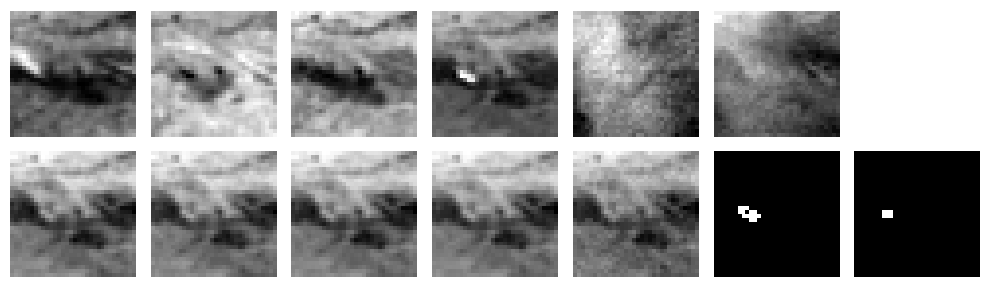

Index 21: Image torch.Size([11, 32, 32]), min/max: -0.2800237238407135/8.310769081115723, Mask (1, 32, 32), min/max: 0.0/1.0


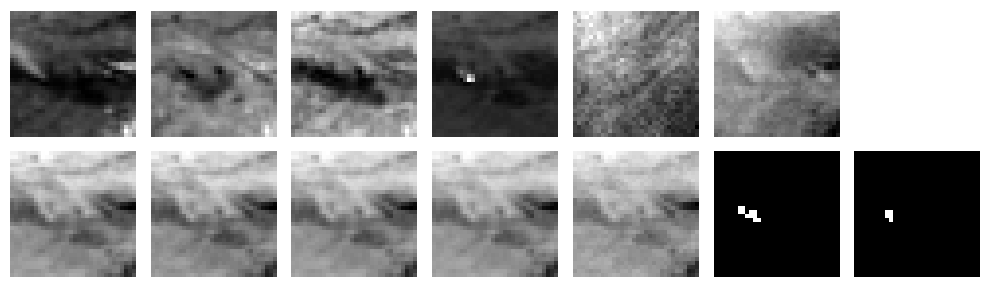

Index 22: Image torch.Size([11, 32, 32]), min/max: -2.2136361598968506/0.3135189116001129, Mask (1, 32, 32), min/max: 0.0/1.0


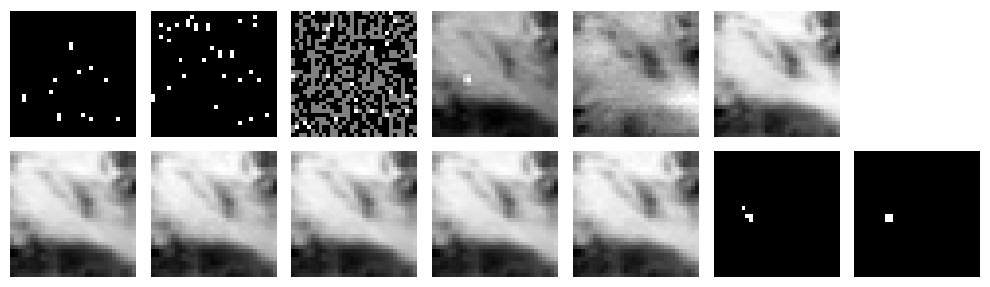

Index 23: Image torch.Size([11, 32, 32]), min/max: -2.751737594604492/6.299334526062012, Mask (1, 32, 32), min/max: 0.0/1.0


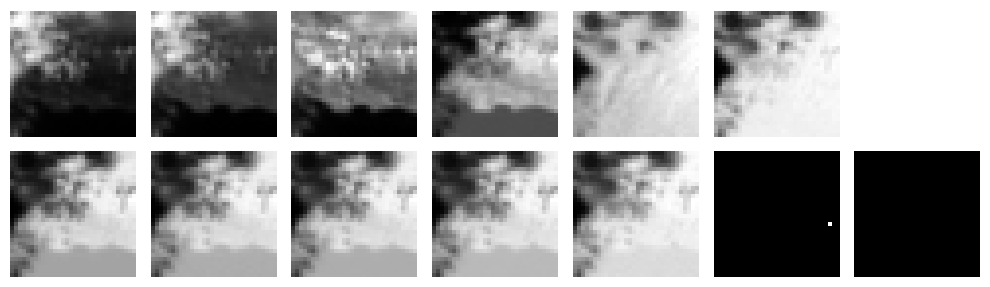

Index 24: Image torch.Size([11, 32, 32]), min/max: -0.6588909029960632/8.370369911193848, Mask (1, 32, 32), min/max: 0.0/1.0


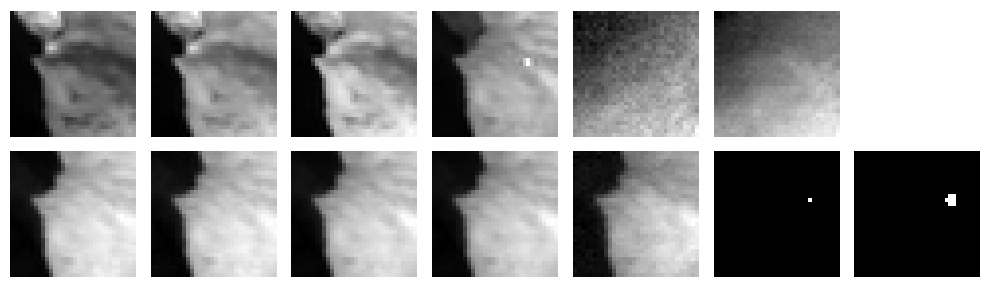

Index 25: Image torch.Size([11, 32, 32]), min/max: -0.6588909029960632/8.84718132019043, Mask (1, 32, 32), min/max: 0.0/1.0


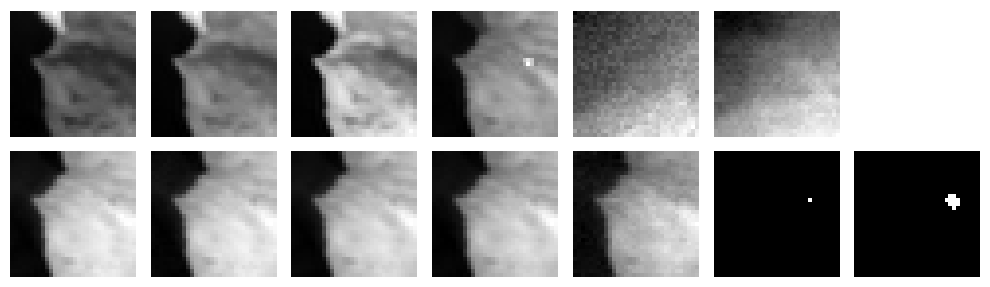

Index 26: Image torch.Size([11, 32, 32]), min/max: -2.5617175102233887/6.650755882263184, Mask (1, 32, 32), min/max: 0.0/1.0


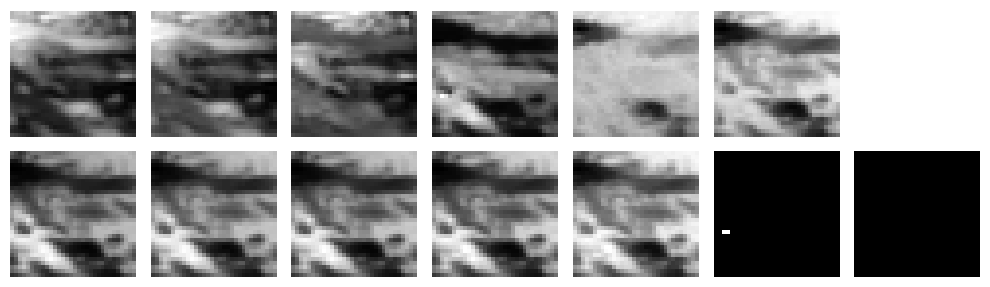

Index 27: Image torch.Size([11, 32, 32]), min/max: -0.6012905836105347/1.5792841911315918, Mask (1, 32, 32), min/max: 0.0/1.0


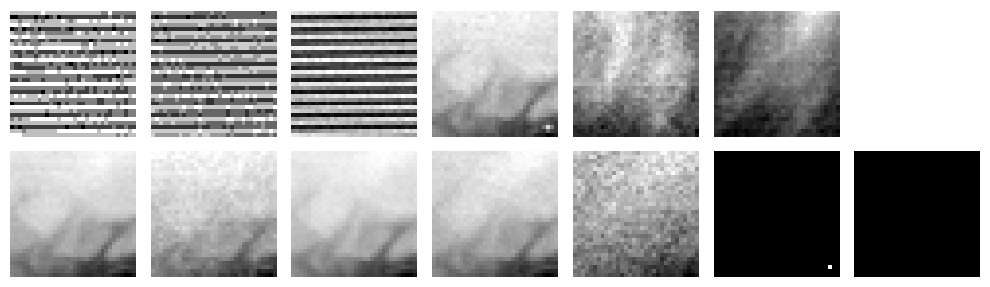

Index 28: Image torch.Size([11, 32, 32]), min/max: -0.7615295648574829/1.5269904136657715, Mask (1, 32, 32), min/max: 0.0/1.0


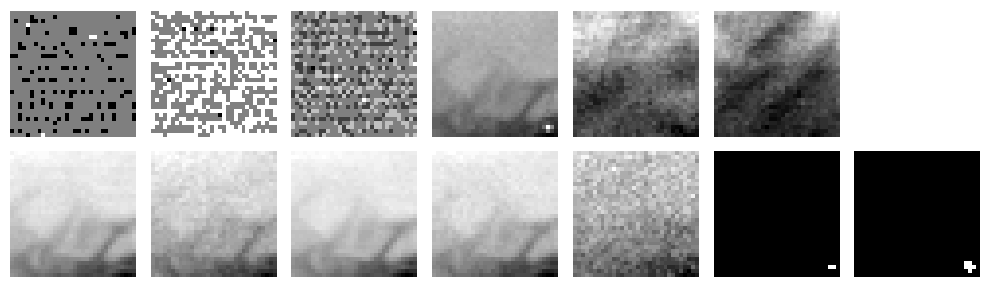

Index 29: Image torch.Size([11, 32, 32]), min/max: -0.7661347389221191/1.6054316759109497, Mask (1, 32, 32), min/max: 0.0/1.0


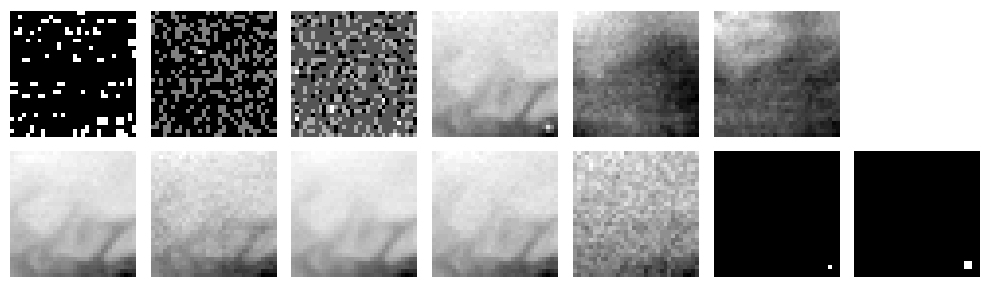

Index 30: Image torch.Size([11, 32, 32]), min/max: -0.6119397282600403/1.1385992765426636, Mask (1, 32, 32), min/max: 0.0/1.0


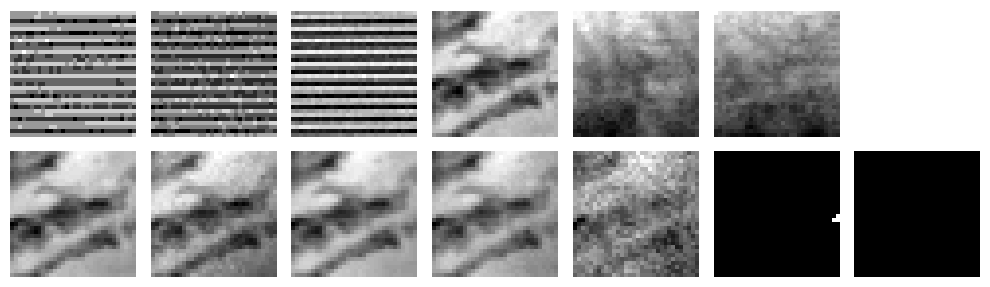

Index 31: Image torch.Size([11, 32, 32]), min/max: -0.6119397282600403/1.1209557056427002, Mask (1, 32, 32), min/max: 0.0/1.0


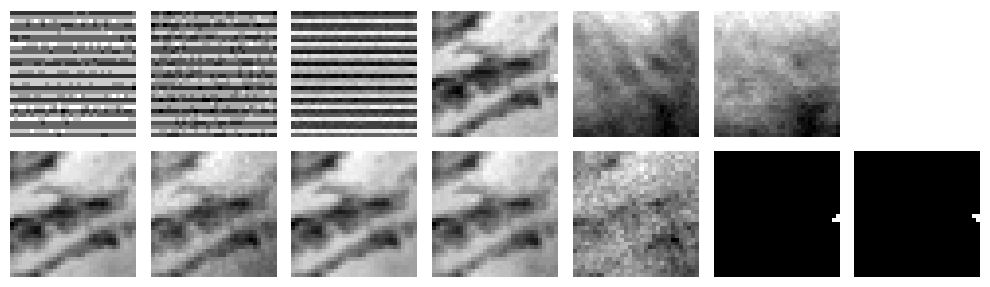

In [16]:
checkpoint_path = glob.glob(os.path.join(trainer.logger.log_dir, "checkpoints", "valid_iou1*"))[0]

print(f"Loading checkpoint from: {checkpoint_path}...")
model = MSGAFModel.load_from_checkpoint(
    checkpoint_path, arch="Unet", encoder_name="resnet18", in_channels=11, out_classes=OUT_CLASSES, encoder_weights=None,
)

# Run validation dataset
valid_metrics = trainer.validate(
    model, dataloaders=msg_af_datamodule.val_dataloader(), verbose=False
)
all_valid_metrics.append(valid_metrics)
print("Validation results:", {k: round(v, 4) for k, v in valid_metrics[0].items()})

# Run test dataset
test_metrics = trainer.test(
    model, dataloaders=msg_af_datamodule.test_dataloader(), verbose=False
)
all_test_metrics.append(test_metrics)
print("Test results:", {k: round(v, 4) for k, v in test_metrics[0].items()})

print("Visualize predictions:")
visualize_predictions(msg_af_datamodule.test_dataset, range(32), model)

In [17]:
! rm -rf lightning_logs/

In [18]:
import pandas as pd

pd.DataFrame(all_valid_metrics).to_csv("vitb4_dice_augm_valid.csv", index=False)
pd.DataFrame(all_test_metrics).to_csv("vitb4_dice_augm_test.csv", index=False)

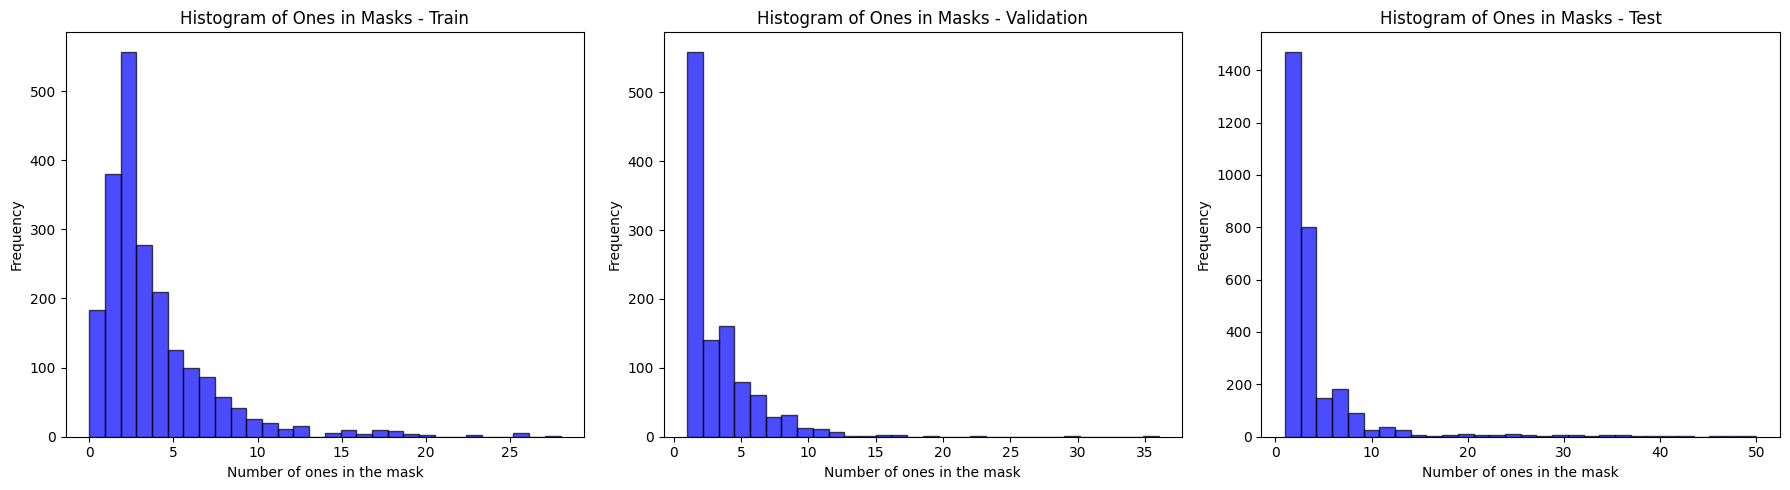

In [19]:
# Initialize the figure and axes for 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Define the datasets to loop through
datasets = {
    "Train": msg_af_datamodule.train_dataset,
    "Validation": msg_af_datamodule.val_dataset,
    "Test": msg_af_datamodule.test_dataset,
}

# Iterate over the datasets and plot histograms in the respective axes
for i, (dataset_name, dataset) in enumerate(datasets.items()):
    ones_counts = []

    # Count the number of ones in each mask
    for data in dataset:
        image, mask = data
        ones_count = mask.sum().item()  # Count the number of ones in the mask
        ones_counts.append(ones_count)

    # Plot the histogram in the respective axis
    axes[i].hist(ones_counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
    axes[i].set_xlabel("Number of ones in the mask")
    axes[i].set_ylabel("Frequency")
    axes[i].set_title(f"Histogram of Ones in Masks - {dataset_name}")

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [20]:
# Define the datasets to loop through
datasets = {
    "Train": msg_af_datamodule.train_dataset,
    "Validation": msg_af_datamodule.val_dataset,
    "Test": msg_af_datamodule.test_dataset,
}

# Iterate over the datasets and print the frequency of each value in the ones_counts list
for dataset_name, dataset in datasets.items():
    ones_counts = []

    # Count the number of ones in each mask
    for data in dataset:
        image, mask = data
        ones_count = mask.sum().item()  # Count the number of ones in the mask
        ones_counts.append(ones_count)

    # Count the frequency of each value in ones_counts using Counter
    count_frequency = Counter(ones_counts)

    # Sort the count_frequency dictionary by the number of ones (the keys)
    sorted_count_frequency = sorted(count_frequency.items())

    # Print the frequency of each value, sorted by number of ones
    print(f"Frequency of ones in {dataset_name} dataset:")
    for count, freq in sorted_count_frequency:
        print(f"  {count} ones: {freq} occurrences")
    print()


Frequency of ones in Train dataset:
  0.0 ones: 174 occurrences
  1.0 ones: 378 occurrences
  2.0 ones: 550 occurrences
  3.0 ones: 280 occurrences
  4.0 ones: 226 occurrences
  5.0 ones: 131 occurrences
  6.0 ones: 99 occurrences
  7.0 ones: 80 occurrences
  8.0 ones: 57 occurrences
  9.0 ones: 42 occurrences
  10.0 ones: 27 occurrences
  11.0 ones: 16 occurrences
  12.0 ones: 18 occurrences
  13.0 ones: 14 occurrences
  14.0 ones: 11 occurrences
  15.0 ones: 6 occurrences
  16.0 ones: 4 occurrences
  17.0 ones: 6 occurrences
  18.0 ones: 3 occurrences
  19.0 ones: 7 occurrences
  20.0 ones: 2 occurrences
  21.0 ones: 2 occurrences
  23.0 ones: 2 occurrences
  25.0 ones: 1 occurrences
  26.0 ones: 3 occurrences
  28.0 ones: 1 occurrences

Frequency of ones in Validation dataset:
  1.0 ones: 238 occurrences
  2.0 ones: 321 occurrences
  3.0 ones: 140 occurrences
  4.0 ones: 160 occurrences
  5.0 ones: 79 occurrences
  6.0 ones: 60 occurrences
  7.0 ones: 29 occurrences
  8.0 ones: 23 o